In [1]:
import kagglehub
nickfratto_pacs_dataset_path = kagglehub.dataset_download('nickfratto/pacs-dataset')

Using Colab cache for faster access to the 'pacs-dataset' dataset.
Data source import complete.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os
import kagglehub # Assuming running in Kaggle environment
import torch.nn.functional as F # Added for softmax in self-training/CDAN
from collections import Counter # For rarest classes F1

In [3]:
# --- Configuration ---
SEED = 42
BATCH_SIZE = 64
NUM_WORKERS = 0 # Recommended for Kaggle
NUM_CLASSES = 7 # PACS dataset has 7 classes
IMAGE_SIZE = 224 # Standard input size for ResNet

# Fix random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [4]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# --- Data Loading and Preprocessing for PACS ---
print("Loading PACS dataset...")
try:
    PACS_basepath = kagglehub.dataset_download("nickfratto/pacs-dataset")

    preprocess = ResNet50_Weights.IMAGENET1K_V2.transforms()

    PACS_photo = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/photo", transform=preprocess)
    PACS_painting = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/art_painting", transform=preprocess)
    PACS_sketch = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/sketch", transform=preprocess)
    PACS_cartoon = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/cartoon", transform=preprocess)

    PACS_photo_dataloader = DataLoader(PACS_photo, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    PACS_painting_dataloader = DataLoader(PACS_painting, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    PACS_sketch_dataloader = DataLoader(PACS_sketch, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    PACS_cartoon_dataloader = DataLoader(PACS_cartoon, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    domain_data = {
        "photo": {"dataset": PACS_photo, "dataloader": PACS_photo_dataloader},
        "art_painting": {"dataset": PACS_painting, "dataloader": PACS_painting_dataloader},
        "sketch": {"dataset": PACS_sketch, "dataloader": PACS_sketch_dataloader},
        "cartoon": {"dataset": PACS_cartoon, "dataloader": PACS_cartoon_dataloader},
    }
    print("PACS datasets loaded successfully.")

except Exception as e:
    print(f"Error loading PACS dataset. Please ensure 'nickfratto/pacs-dataset' is correctly downloaded and accessible. Error: {e}")
    # Exit or handle error gracefully if dataset isn't available
    exit()

Loading PACS dataset...
Using Colab cache for faster access to the 'pacs-dataset' dataset.
PACS datasets loaded successfully.


In [6]:
# --- Model Backbone: ResNet-50 ---
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x # Output features are of size 2048

class Classifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [7]:
# --- Evaluation Function ---
def evaluate_model(feature_extractor, classifier, dataloader, domain_name="Unknown"):
    feature_extractor.eval()
    classifier.eval()
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            features = feature_extractor(inputs)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples
    print(f"Domain: {domain_name}, Accuracy: {accuracy:.4f}")
    return accuracy, np.array(all_preds), np.array(all_labels)

In [8]:


# --- t-SNE Visualization Utility ---
def visualize_features_tsne(feature_extractor, source_dataloader, target_dataloader, title="t-SNE Visualization", filename="tsne.png"):
    feature_extractor.eval()
    all_features = []
    all_labels = []
    all_domains = [] # 0 for source, 1 for target

    print("Extracting features for t-SNE visualization...")
    with torch.no_grad():
        for inputs, labels in tqdm(source_dataloader, desc="Source Features"):
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_domains.append(np.zeros(len(labels)))

        for inputs, labels in tqdm(target_dataloader, desc="Target Features"):
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_domains.append(np.ones(len(labels)))

    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)
    all_domains = np.hstack(all_domains)

    # Randomly sample a subset for t-SNE if dataset is too large (e.g., > 5000 samples)
    if len(all_features) > 5000:
        print(f"Reducing {len(all_features)} samples for t-SNE to 5000 for performance.")
        indices = np.random.choice(len(all_features), 5000, replace=False)
        all_features = all_features[indices]
        all_labels = all_labels[indices]
        all_domains = all_domains[indices]

    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30) # Adjust perplexity as needed
    tsne_results = tsne.fit_transform(all_features)

    plt.figure(figsize=(12, 10))
    # Plot by domain
    plt.subplot(1, 2, 1)
    scatter_s = plt.scatter(tsne_results[all_domains == 0, 0], tsne_results[all_domains == 0, 1],
                            c=all_labels[all_domains == 0], cmap='viridis', s=10, alpha=0.6, label='Source')
    scatter_t = plt.scatter(tsne_results[all_domains == 1, 0], tsne_results[all_domains == 1, 1],
                            c=all_labels[all_domains == 1], cmap='plasma', s=10, alpha=0.6, marker='x', label='Target')
    plt.title(f"{title} (Domain Separation)")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend()
    plt.colorbar(scatter_s, label='Class Label (Source)')
    plt.colorbar(scatter_t, label='Class Label (Target)')


    # Plot by class, differentiating source/target with markers
    plt.subplot(1, 2, 2)
    for i in range(NUM_CLASSES):
        class_source_mask = (all_labels == i) & (all_domains == 0)
        plt.scatter(tsne_results[class_source_mask, 0], tsne_results[class_source_mask, 1],
                    label=f'Class {i} (Source)', s=20, alpha=0.7, marker='o', color=plt.cm.tab10(i))

        class_target_mask = (all_labels == i) & (all_domains == 1)
        plt.scatter(tsne_results[class_target_mask, 0], tsne_results[class_target_mask, 1],
                    label=f'Class {i} (Target)', s=20, alpha=0.7, marker='x', color=plt.cm.tab10(i))

    plt.title(f"{title} (Class Separation)")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"t-SNE visualization saved to {filename}")

# --- Confusion Matrix Visualization ---
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix", filename="confusion_matrix.png"):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Confusion matrix saved to {filename}")

# --- Proxy Distance for Domain Alignment Utility ---
class DomainDiscriminator(nn.Module):
    def __init__(self, feature_dim):
        super(DomainDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)

def calculate_domain_distance_proxy(feature_extractor, source_dataloader, target_dataloader):
    discriminator = DomainDiscriminator(2048).to(device)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=1e-3)
    criterion_disc = nn.BCELoss()

    all_features = []
    all_domains_labels = []

    feature_extractor.eval()
    with torch.no_grad():
        for inputs, _ in source_dataloader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            all_features.append(features.cpu())
            all_domains_labels.append(torch.zeros(len(inputs)))
        for inputs, _ in target_dataloader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            all_features.append(features.cpu())
            all_domains_labels.append(torch.ones(len(inputs)))

    all_features = torch.cat(all_features, dim=0)
    all_domains_labels = torch.cat(all_domains_labels, dim=0).unsqueeze(1)

    class FeatureDataset(Dataset):
        def __init__(self, features, labels):
            self.features = features
            self.labels = labels
        def __len__(self):
            return len(self.features)
        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]

    feature_dataset = FeatureDataset(all_features, all_domains_labels)
    feature_dataloader = DataLoader(feature_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    print("Training Domain Discriminator for proxy distance...")
    for epoch in range(5): # Fewer epochs as it's just a proxy
        discriminator.train()
        total_loss = 0
        for features_batch, domain_labels_batch in feature_dataloader:
            features_batch, domain_labels_batch = features_batch.to(device), domain_labels_batch.to(device)
            optimizer_disc.zero_grad()
            preds = discriminator(features_batch)
            loss = criterion_disc(preds, domain_labels_batch)
            loss.backward()
            optimizer_disc.step()
            total_loss += loss.item()

    discriminator.eval()
    correct_domain_preds = 0
    total_domain_samples = 0
    with torch.no_grad():
        for features_batch, domain_labels_batch in feature_dataloader:
            features_batch, domain_labels_batch = features_batch.to(device), domain_labels_batch.to(device)
            preds = discriminator(features_batch)
            predicted_domains = (preds > 0.5).float()
            total_domain_samples += domain_labels_batch.size(0)
            correct_domain_preds += (predicted_domains == domain_labels_batch).sum().item()

    domain_discriminator_accuracy = correct_domain_preds / total_domain_samples
    # Proxy distance = 1 - accuracy (lower accuracy means features are more mixed, thus better aligned)
    # Or simply report the error rate
    domain_discriminator_error = 1 - domain_discriminator_accuracy
    return domain_discriminator_error




In [35]:
# --- Select Source and Target Domains ---
SOURCE_DOMAIN_NAME = "photo"
TARGET_DOMAIN_NAME = "art_painting"

source_dataloader = domain_data[SOURCE_DOMAIN_NAME]["dataloader"]
target_dataloader = domain_data[TARGET_DOMAIN_NAME]["dataloader"]

target_test_dataset = datasets.ImageFolder(
    root=f"{PACS_basepath}/dct2_images/dct2_images/{TARGET_DOMAIN_NAME}",
    transform=preprocess
)
target_test_dataloader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

source_test_dataset = datasets.ImageFolder(
    root=f"{PACS_basepath}/dct2_images/dct2_images/{SOURCE_DOMAIN_NAME}",
    transform=preprocess
)
source_test_dataloader = DataLoader(source_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


CLASS_NAMES = PACS_photo.classes
print(f"Selected Source Domain: {SOURCE_DOMAIN_NAME}")
print(f"Selected Target Domain: {TARGET_DOMAIN_NAME}")
print(f"Class Names: {CLASS_NAMES}")

Selected Source Domain: photo
Selected Target Domain: art_painting
Class Names: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [36]:
# --- Task 1.1 Specific Code ---
print("\n" + "="*80)
print("Task 1.1: Source-Only Baseline")
print("="*80 + "\n")

# Model Initialization
feature_extractor_so = FeatureExtractor().to(device)
classifier_so = Classifier(2048, NUM_CLASSES).to(device)

optimizer_so = optim.Adam(list(feature_extractor_so.parameters()) + list(classifier_so.parameters()), lr=1e-3)
criterion_so = nn.CrossEntropyLoss()

NUM_EPOCHS_SO = 20

print(f"Training Source-Only model on {SOURCE_DOMAIN_NAME} for {NUM_EPOCHS_SO} epochs...")



Task 1.1: Source-Only Baseline

Training Source-Only model on photo for 20 epochs...


In [37]:
# Training Loop (Source-Only)
for epoch in range(NUM_EPOCHS_SO):
    feature_extractor_so.train()
    classifier_so.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(source_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_SO} (Source-Only Training)")):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_so.zero_grad()
        features = feature_extractor_so(inputs)
        outputs = classifier_so(features)
        loss = criterion_so(outputs, labels)
        loss.backward()
        optimizer_so.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss / len(source_dataloader):.4f}")

print("\n--- Source-Only Training Complete ---")

Epoch 1/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Epoch 1 Loss: 1.5387


Epoch 2/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Epoch 2 Loss: 1.0690


Epoch 3/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Epoch 3 Loss: 0.8158


Epoch 4/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Epoch 4 Loss: 0.5690


Epoch 5/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Epoch 5 Loss: 0.3723


Epoch 6/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Epoch 6 Loss: 0.3827


Epoch 7/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Epoch 7 Loss: 0.2602


Epoch 8/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Epoch 8 Loss: 0.2321


Epoch 9/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Epoch 9 Loss: 0.2711


Epoch 10/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Epoch 10 Loss: 0.1192


Epoch 11/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Epoch 11 Loss: 0.0579


Epoch 12/20 (Source-Only Training): 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch 12 Loss: 0.2664


Epoch 13/20 (Source-Only Training): 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch 13 Loss: 0.2491


Epoch 14/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Epoch 14 Loss: 0.1174


Epoch 15/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Epoch 15 Loss: 0.3023


Epoch 16/20 (Source-Only Training): 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Epoch 16 Loss: 0.2289


Epoch 17/20 (Source-Only Training): 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 17 Loss: 0.0589


Epoch 18/20 (Source-Only Training): 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]


Epoch 18 Loss: 0.1328


Epoch 19/20 (Source-Only Training): 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Epoch 19 Loss: 0.2046


Epoch 20/20 (Source-Only Training): 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]

Epoch 20 Loss: 0.0555

--- Source-Only Training Complete ---


In [38]:
# Evaluation (Source-Only)
print("\nEvaluating Source-Only model:")
source_accuracy, source_preds_so, source_labels_so = evaluate_model(feature_extractor_so, classifier_so, source_test_dataloader, domain_name=SOURCE_DOMAIN_NAME)
target_accuracy_so, target_preds_so, target_labels_so = evaluate_model(feature_extractor_so, classifier_so, target_test_dataloader, domain_name=TARGET_DOMAIN_NAME)

print(f"\nResults for Source-Only Baseline ({SOURCE_DOMAIN_NAME} -> {TARGET_DOMAIN_NAME}):")
print(f"  Source Domain Accuracy ({SOURCE_DOMAIN_NAME}): {source_accuracy:.4f}")
print(f"  Target Domain Accuracy ({TARGET_DOMAIN_NAME}): {target_accuracy_so:.4f}")
print(f"  Accuracy Drop (Source - Target): {source_accuracy - target_accuracy_so:.4f}")


Evaluating Source-Only model:
Domain: photo, Accuracy: 0.9898
Domain: art_painting, Accuracy: 0.2559

Results for Source-Only Baseline (photo -> art_painting):
  Source Domain Accuracy (photo): 0.9898
  Target Domain Accuracy (art_painting): 0.2559
  Accuracy Drop (Source - Target): 0.7340



Generating visualizations for Source-Only model...
Extracting features for t-SNE visualization...


Target Features: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Running t-SNE...


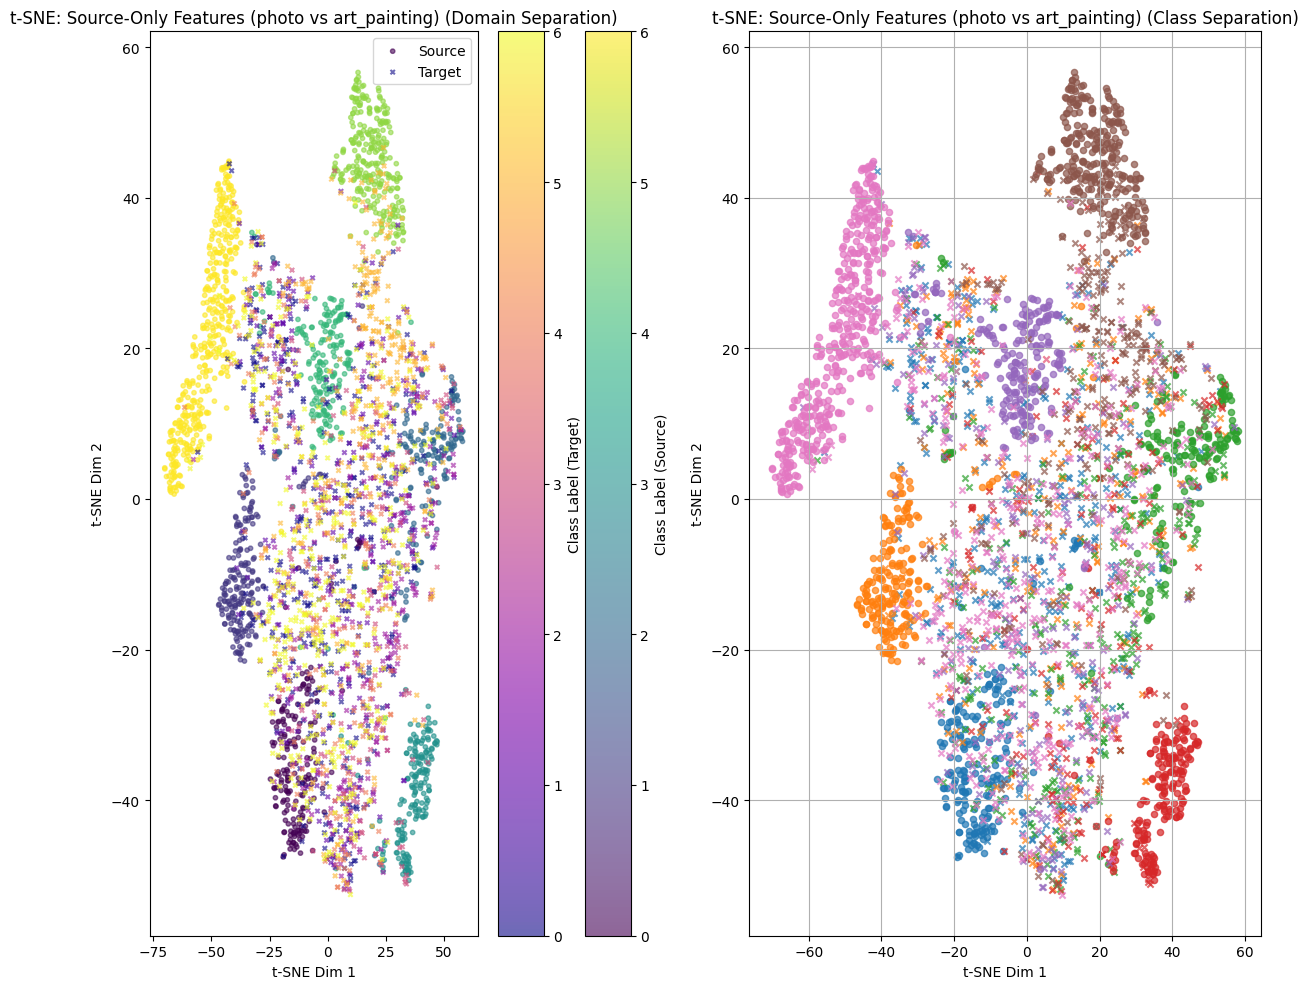

t-SNE visualization saved to tsne_source_only.png


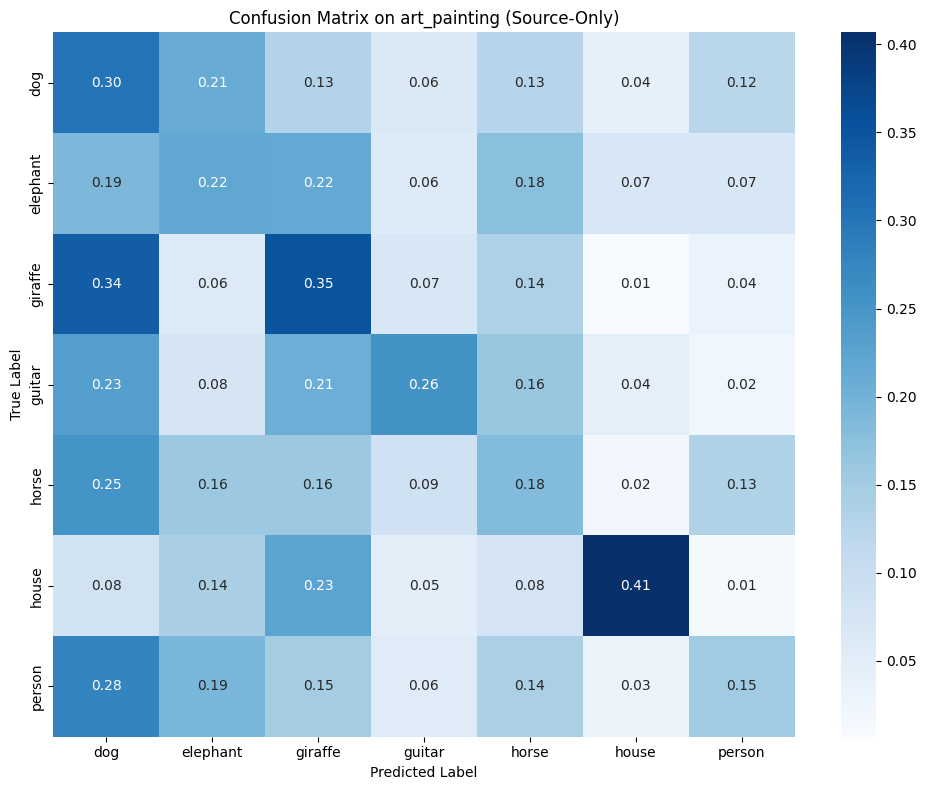

Confusion matrix saved to confusion_matrix_source_only.png

--- Analysis of Source-Only Baseline ---
The large drop in accuracy from the source domain to the target domain clearly illustrates the effect of domain shift.
In this case, the model trained on 'photo' images struggles significantly when presented with 'art_painting' images.
Nature of domain shift: The PACS dataset involves diverse visual styles.
'photo' images are real-world photographs, while 'art_painting' images are artistic renderings.
Key differences include: color palettes, textures, outlines, level of detail, lighting, and general artistic abstraction.
For example, a 'dog' in a photograph looks very different from a 'dog' in a painting (e.g., brushstrokes, exaggerated features).
The source-trained model learns features discriminative for photographs, but these features may not be robust or relevant in the target domain.
This degradation is exactly what domain adaptation aims to address, as the model's learned decision

In [ ]:
# Visualization and Analysis (Source-Only)
print("\nGenerating visualizations for Source-Only model...")
visualize_features_tsne(feature_extractor_so, source_test_dataloader, target_test_dataloader,
                        title=f"t-SNE: Source-Only Features ({SOURCE_DOMAIN_NAME} vs {TARGET_DOMAIN_NAME})",
                        filename="tsne_source_only.png")
plot_confusion_matrix(target_labels_so, target_preds_so, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (Source-Only)",
                      filename="confusion_matrix_source_only.png")


In [ ]:
# Save the trained model for subsequent notebooks
torch.save(feature_extractor_so.state_dict(), "feature_extractor_so.pth")
torch.save(classifier_so.state_dict(), "classifier_so.pth")
print("\nSource-Only model weights saved for Task 1.2 and 1.3.")


Source-Only model weights saved for Task 1.2 and 1.3.


In [ ]:
CLASS_NAMES = PACS_photo.classes
print(f"Selected Source Domain: {SOURCE_DOMAIN_NAME}")
print(f"Selected Target Domain: {TARGET_DOMAIN_NAME}")
print(f"Class Names: {CLASS_NAMES}")

feature_extractor_so_ref = FeatureExtractor().to(device)
classifier_so_ref = Classifier(2048, NUM_CLASSES).to(device)
try:
    feature_extractor_so_ref.load_state_dict(torch.load("feature_extractor_so.pth"))
    classifier_so_ref.load_state_dict(torch.load("classifier_so.pth"))
    # Evaluate Source-Only as a baseline in this notebook
    so_source_acc, _, _ = evaluate_model(feature_extractor_so_ref, classifier_so_ref, source_test_dataloader, domain_name=f"{SOURCE_DOMAIN_NAME} (SO Ref)")
    so_target_acc, _, _ = evaluate_model(feature_extractor_so_ref, classifier_so_ref, target_test_dataloader, domain_name=f"{TARGET_DOMAIN_NAME} (SO Ref)")
    source_only_results = {"Source Accuracy": so_source_acc, "Target Accuracy": so_target_acc} # Store for final comparison
except FileNotFoundError:
    print("Source-Only model weights not found. Proceeding with fresh ImageNet pre-trained initialization.")
    print("Please ensure Task 1.1 notebook is run first if you intend to reuse its trained model.")
    # Initialize a dummy source_only_results for comparison if weights not loaded
    source_only_results = {"Source Accuracy": 0, "Target Accuracy": 0}

Selected Source Domain: photo
Selected Target Domain: art_painting
Class Names: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Attempting to load Source-Only model weights for reference/initialization...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s] 


Source-Only model weights loaded successfully.
Domain: photo (SO Ref), Accuracy: 0.9982
Domain: art_painting (SO Ref), Accuracy: 0.2651


In [11]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

BATCH_SIZE = 16  # reduce if OOM persists
NUM_WORKERS = 0  # safer on Kaggle

source_dataloader = DataLoader(
    domain_data[SOURCE_DOMAIN_NAME]["dataset"],
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
target_dataloader = DataLoader(
    domain_data[TARGET_DOMAIN_NAME]["dataset"],
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

In [12]:
# --- Task 1.2.1 Deep Alignment Network (DAN) with MMD ---
print("\n" + "="*80)
print("Task 1.2.1: Deep Alignment Network (DAN) with MMD")
print("="*80 + "\n")

# MMD Loss Implementation
class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        self.kernel_type = kernel_type

    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0 - total1)**2).sum(2)

        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2 - n_samples)
            bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)


    def forward(self, source, target):
        if self.kernel_type == 'rbf':
            batch_size = source.size(0)
            kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul,
                                         kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = kernels[:batch_size, :batch_size]
            YY = kernels[batch_size:, batch_size:]
            XY = kernels[:batch_size, batch_size:]
            YX = kernels[batch_size:, :batch_size]
            loss = torch.mean(XX + YY - XY - YX)
            return loss
        else:
            raise NotImplementedError(f"Kernel type {self.kernel_type} not implemented.")



Task 1.2.1: Deep Alignment Network (DAN) with MMD



In [13]:
# Model Initialization for DAN
feature_extractor_dan = FeatureExtractor().to(device)
classifier_dan = Classifier(2048, NUM_CLASSES).to(device)

optimizer_dan = optim.Adam(list(feature_extractor_dan.parameters()) + list(classifier_dan.parameters()), lr=1e-3)
criterion_dan_cls = nn.CrossEntropyLoss()
criterion_dan_mmd = MMDLoss(kernel_type='rbf').to(device)

NUM_EPOCHS_DAN = 20
ALPHA_MMD = 1.0 # Weight for MMD loss

print(f"Training DAN model on {SOURCE_DOMAIN_NAME} (labeled) and {TARGET_DOMAIN_NAME} (unlabeled) for {NUM_EPOCHS_DAN} epochs...")

Training DAN model on photo (labeled) and art_painting (unlabeled) for 20 epochs...


In [14]:
# Training Loop (DAN)
len_source_dataloader = len(source_dataloader)
len_target_dataloader = len(target_dataloader)
min_len_dataloader = min(len_source_dataloader, len_target_dataloader)

for epoch in range(NUM_EPOCHS_DAN):
    feature_extractor_dan.train()
    classifier_dan.train()
    running_loss_cls = 0.0
    running_loss_mmd = 0.0

    source_iter = iter(source_dataloader)
    target_iter = iter(target_dataloader)

    for i in tqdm(range(min_len_dataloader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS_DAN} (DAN Training)"):
        try:
            s_inputs, s_labels = next(source_iter)
        except StopIteration:
            source_iter = iter(source_dataloader)
            s_inputs, s_labels = next(source_iter)

        try:
            t_inputs, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_dataloader)
            t_inputs, _ = next(target_iter)

        s_inputs, s_labels = s_inputs.to(device), s_labels.to(device)
        t_inputs = t_inputs.to(device)

        optimizer_dan.zero_grad()

        s_features = feature_extractor_dan(s_inputs)
        s_outputs = classifier_dan(s_features)
        loss_cls = criterion_dan_cls(s_outputs, s_labels)

        t_features = feature_extractor_dan(t_inputs)

        # Skip if batch sizes mismatch
        if s_features.size(0) != t_features.size(0):
            continue

        loss_mmd = criterion_dan_mmd(s_features, t_features)

        total_loss = loss_cls + ALPHA_MMD * loss_mmd
        total_loss.backward()
        optimizer_dan.step()

        running_loss_cls += loss_cls.item()
        running_loss_mmd += loss_mmd.item()

    print(f"Epoch {epoch+1} Class Loss: {running_loss_cls / min_len_dataloader:.4f}, MMD Loss: {running_loss_mmd / min_len_dataloader:.4f}")

print("\n--- DAN Training Complete ---")



Epoch 1/20 (DAN Training): 100%|██████████| 105/105 [01:07<00:00,  1.56it/s]


Epoch 1 Class Loss: 1.8983, MMD Loss: 0.2070


Epoch 2/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.23it/s]


Epoch 2 Class Loss: 1.8838, MMD Loss: 0.2327


Epoch 3/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 3 Class Loss: 1.8763, MMD Loss: 0.2590


Epoch 4/20 (DAN Training): 100%|██████████| 105/105 [00:45<00:00,  2.30it/s]


Epoch 4 Class Loss: 1.8741, MMD Loss: 0.2961


Epoch 5/20 (DAN Training): 100%|██████████| 105/105 [00:45<00:00,  2.30it/s]


Epoch 5 Class Loss: 1.8740, MMD Loss: 0.2250


Epoch 6/20 (DAN Training): 100%|██████████| 105/105 [00:45<00:00,  2.32it/s]


Epoch 6 Class Loss: 1.8737, MMD Loss: 0.2751


Epoch 7/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 7 Class Loss: 1.8752, MMD Loss: 0.2686


Epoch 8/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 8 Class Loss: 1.8747, MMD Loss: 0.2227


Epoch 9/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 9 Class Loss: 1.8752, MMD Loss: 0.3935


Epoch 10/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 10 Class Loss: 1.8782, MMD Loss: 0.2735


Epoch 11/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 11 Class Loss: 1.8761, MMD Loss: 0.2461


Epoch 12/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 12 Class Loss: 1.8745, MMD Loss: 0.3012


Epoch 13/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 13 Class Loss: 1.8775, MMD Loss: 0.2782


Epoch 14/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 14 Class Loss: 1.8786, MMD Loss: 0.3277


Epoch 15/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 15 Class Loss: 1.8769, MMD Loss: 0.2789


Epoch 16/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 16 Class Loss: 1.8760, MMD Loss: 0.3218


Epoch 17/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 17 Class Loss: 1.8761, MMD Loss: 0.3149


Epoch 18/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 18 Class Loss: 1.8746, MMD Loss: 0.3327


Epoch 19/20 (DAN Training): 100%|██████████| 105/105 [00:47<00:00,  2.23it/s]


Epoch 19 Class Loss: 1.8742, MMD Loss: 0.3488


Epoch 20/20 (DAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]

Epoch 20 Class Loss: 1.8735, MMD Loss: 0.3422

--- DAN Training Complete ---


In [15]:
# Evaluation (DAN)
print("\nEvaluating DAN model:")
source_accuracy_dan, source_preds_dan, source_labels_dan = evaluate_model(feature_extractor_dan, classifier_dan, source_test_dataloader, domain_name=SOURCE_DOMAIN_NAME)
target_accuracy_dan, target_preds_dan, target_labels_dan = evaluate_model(feature_extractor_dan, classifier_dan, target_test_dataloader, domain_name=TARGET_DOMAIN_NAME)

print(f"\nResults for DAN ({SOURCE_DOMAIN_NAME} -> {TARGET_DOMAIN_NAME}):")
print(f"  Source Domain Accuracy ({SOURCE_DOMAIN_NAME}): {source_accuracy_dan:.4f}")
print(f"  Target Domain Accuracy ({TARGET_DOMAIN_NAME}): {target_accuracy_dan:.4f}")


Evaluating DAN model:
Domain: photo, Accuracy: 0.2587
Domain: art_painting, Accuracy: 0.2192

Results for DAN (photo -> art_painting):
  Source Domain Accuracy (photo): 0.2587
  Target Domain Accuracy (art_painting): 0.2192



Generating visualizations for DAN model...
Extracting features for t-SNE visualization...


Target Features: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Running t-SNE...


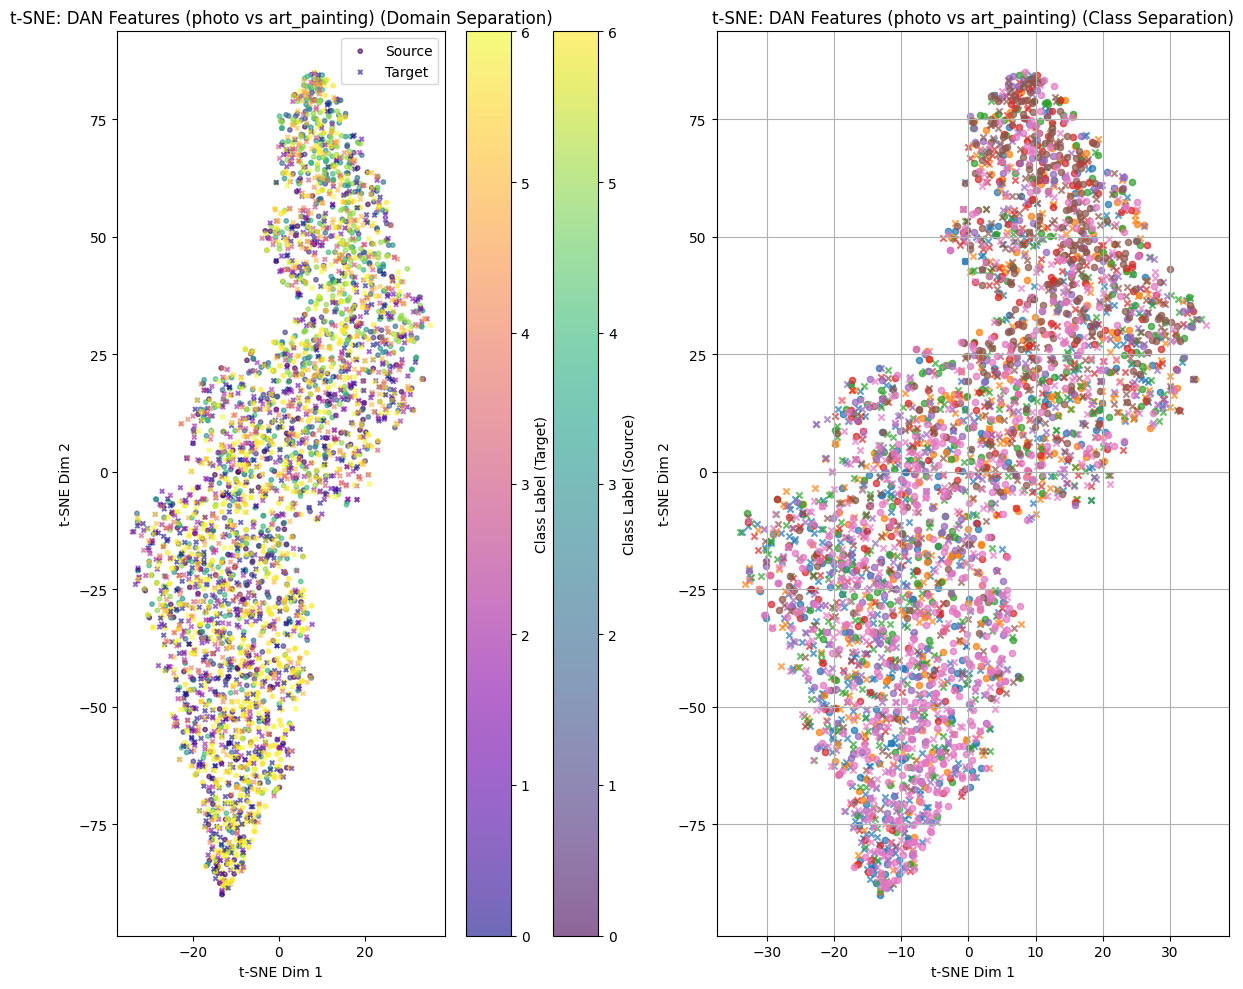

t-SNE visualization saved to tsne_dan.png


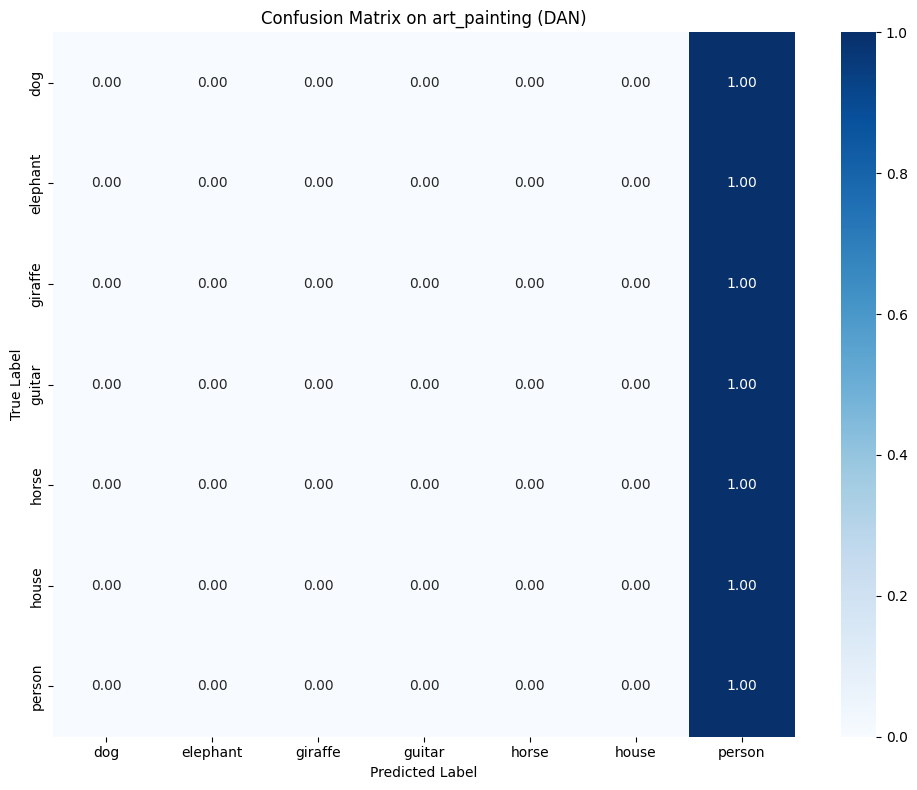

Confusion matrix saved to confusion_matrix_dan.png


In [16]:
# Visualization and Analysis (DAN)
print("\nGenerating visualizations for DAN model...")
visualize_features_tsne(feature_extractor_dan, source_test_dataloader, target_test_dataloader,
                        title=f"t-SNE: DAN Features ({SOURCE_DOMAIN_NAME} vs {TARGET_DOMAIN_NAME})",
                        filename="tsne_dan.png")

plot_confusion_matrix(target_labels_dan, target_preds_dan, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (DAN)",
                      filename="confusion_matrix_dan.png")


In [ ]:
# Proxy Distance for Domain Alignment (DAN)
domain_discriminator_error_dan = calculate_domain_distance_proxy(feature_extractor_dan, source_test_dataloader, target_test_dataloader)
print(f"Proxy Domain Distance (Discriminator Error) for DAN: {domain_discriminator_error_dan:.4f}")

Training Domain Discriminator for proxy distance...
Proxy Domain Distance (Discriminator Error) for DAN: 0.4492


In [ ]:
# Storing results for comparison
dan_results = {
    "Source Accuracy": source_accuracy_dan,
    "Target Accuracy": target_accuracy_dan,
    "Target Preds": target_preds_dan,
    "Target Labels": target_labels_dan,
    "Proxy Domain Distance": domain_discriminator_error_dan
}

In [17]:
# --- Task 1.2.2 Domain Adversarial Neural Network (DANN) ---
print("\n" + "="*80)
print("Task 1.2.2: Domain Adversarial Neural Network (DANN)")
print("="*80 + "\n")

# Gradient Reversal Layer
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class GRL(nn.Module):
    def __init__(self, alpha=1.0):
        super(GRL, self).__init__()
        self.alpha = torch.tensor(alpha, requires_grad=False)

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)


Task 1.2.2: Domain Adversarial Neural Network (DANN)



In [18]:
# DANN Model Architecture
class DANNModel(nn.Module):
    def __init__(self, feature_extractor, num_classes, feature_dim=2048):
        super(DANNModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = Classifier(feature_dim, num_classes)
        self.grl = GRL()

        self.domain_classifier = nn.Sequential(
            nn.Linear(feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        class_output = self.classifier(features)
        self.grl.alpha = torch.tensor(alpha, requires_grad=False).to(x.device) # Update alpha
        reversed_features = self.grl(features)
        domain_output = self.domain_classifier(reversed_features)
        return class_output, domain_output, features

In [19]:
# Model Initialization for DANN
feature_extractor_dann = FeatureExtractor().to(device) # Shared feature extractor
dann_model = DANNModel(feature_extractor_dann, NUM_CLASSES, feature_dim=2048).to(device)

optimizer_dann = optim.Adam(dann_model.parameters(), lr=1e-3)
criterion_dann_cls = nn.CrossEntropyLoss()
criterion_dann_domain = nn.BCELoss()

NUM_EPOCHS_DANN = 20
LAMBDA_DANN = 1.0

print(f"Training DANN model on {SOURCE_DOMAIN_NAME} (labeled) and {TARGET_DOMAIN_NAME} (unlabeled) for {NUM_EPOCHS_DANN} epochs...")

Training DANN model on photo (labeled) and art_painting (unlabeled) for 20 epochs...


In [20]:
# Training Loop (DANN)
len_source_dataloader = len(source_dataloader)
len_target_dataloader = len(target_dataloader)
min_len_dataloader = min(len_source_dataloader, len_target_dataloader)

for epoch in range(NUM_EPOCHS_DANN):
    dann_model.train()
    running_loss_cls = 0.0
    running_loss_domain = 0.0

    source_iter = iter(source_dataloader)
    target_iter = iter(target_dataloader)

    alpha = 1.0 # Keeping alpha constant for simplicity, but can be scheduled

    for i in tqdm(range(min_len_dataloader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS_DANN} (DANN Training)"):
        try:
            s_inputs, s_labels = next(source_iter)
        except StopIteration:
            source_iter = iter(source_dataloader)
            s_inputs, s_labels = next(source_iter)

        try:
            t_inputs, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_dataloader)
            t_inputs, _ = next(target_iter)

        s_inputs, s_labels = s_inputs.to(device), s_labels.to(device)
        t_inputs = t_inputs.to(device)

        optimizer_dann.zero_grad()

        # Source Domain Pass
        s_class_output, s_domain_output, _ = dann_model(s_inputs, alpha=alpha)
        loss_cls = criterion_dann_cls(s_class_output, s_labels)

        s_domain_label = torch.zeros(s_inputs.size(0), 1).to(device)
        loss_s_domain = criterion_dann_domain(s_domain_output, s_domain_label)

        # Target Domain Pass
        _, t_domain_output, _ = dann_model(t_inputs, alpha=alpha)
        t_domain_label = torch.ones(t_inputs.size(0), 1).to(device)
        loss_t_domain = criterion_dann_domain(t_domain_output, t_domain_label)

        loss_domain = loss_s_domain + loss_t_domain

        total_loss = loss_cls + LAMBDA_DANN * loss_domain
        total_loss.backward()
        optimizer_dann.step()

        running_loss_cls += loss_cls.item()
        running_loss_domain += loss_domain.item()

    print(f"Epoch {epoch+1} Class Loss: {running_loss_cls / min_len_dataloader:.4f}, Domain Loss: {running_loss_domain / min_len_dataloader:.4f}")

print("\n--- DANN Training Complete ---")


Epoch 1/20 (DANN Training): 100%|██████████| 105/105 [00:48<00:00,  2.17it/s]


Epoch 1 Class Loss: 1.5538, Domain Loss: 1.4015


Epoch 2/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 2 Class Loss: 1.1463, Domain Loss: 1.3690


Epoch 3/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 3 Class Loss: 1.0088, Domain Loss: 1.3405


Epoch 4/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 4 Class Loss: 0.8591, Domain Loss: 1.3183


Epoch 5/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 5 Class Loss: 0.8634, Domain Loss: 1.3289


Epoch 6/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 6 Class Loss: 0.7636, Domain Loss: 1.3202


Epoch 7/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 7 Class Loss: 0.6977, Domain Loss: 1.3115


Epoch 8/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 8 Class Loss: 0.6393, Domain Loss: 1.3461


Epoch 9/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 9 Class Loss: 0.5070, Domain Loss: 1.3338


Epoch 10/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 10 Class Loss: 0.3399, Domain Loss: 1.3336


Epoch 11/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 11 Class Loss: 0.3488, Domain Loss: 1.3403


Epoch 12/20 (DANN Training): 100%|██████████| 105/105 [00:45<00:00,  2.28it/s]


Epoch 12 Class Loss: 0.3506, Domain Loss: 1.3354


Epoch 13/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.28it/s]


Epoch 13 Class Loss: 0.2558, Domain Loss: 1.3389


Epoch 14/20 (DANN Training): 100%|██████████| 105/105 [00:45<00:00,  2.28it/s]


Epoch 14 Class Loss: 0.2409, Domain Loss: 1.3550


Epoch 15/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.28it/s]


Epoch 15 Class Loss: 0.2528, Domain Loss: 1.3264


Epoch 16/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.28it/s]


Epoch 16 Class Loss: 0.2482, Domain Loss: 1.3378


Epoch 17/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.28it/s]


Epoch 17 Class Loss: 0.2363, Domain Loss: 1.3258


Epoch 18/20 (DANN Training): 100%|██████████| 105/105 [00:45<00:00,  2.29it/s]


Epoch 18 Class Loss: 0.2071, Domain Loss: 1.3414


Epoch 19/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.28it/s]


Epoch 19 Class Loss: 0.2089, Domain Loss: 1.3245


Epoch 20/20 (DANN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]

Epoch 20 Class Loss: 0.2159, Domain Loss: 1.3193

--- DANN Training Complete ---


In [32]:

# Evaluation (DANN)
print("\nEvaluating DANN model:")
dann_model.eval()
feature_extractor_dann.eval()

temp_classifier_dann = dann_model.classifier

source_accuracy_dann_eval, source_preds_dann_eval, source_labels_dann_eval = evaluate_model(feature_extractor_dann, temp_classifier_dann, source_test_dataloader, domain_name=SOURCE_DOMAIN_NAME)
target_accuracy_dann_eval, target_preds_dann_eval, target_labels_dann_eval = evaluate_model(feature_extractor_dann, temp_classifier_dann, target_test_dataloader, domain_name=TARGET_DOMAIN_NAME)

print(f"\nResults for DANN ({SOURCE_DOMAIN_NAME} -> {TARGET_DOMAIN_NAME}):")
print(f"  Source Domain Accuracy ({SOURCE_DOMAIN_NAME}): {source_accuracy_dann_eval:.4f}")
print(f"  Target Domain Accuracy ({TARGET_DOMAIN_NAME}): {target_accuracy_dann_eval:.4f}")


Evaluating DANN model:
Domain: photo, Accuracy: 0.9593
Domain: art_painting, Accuracy: 0.2866

Results for DANN (photo -> art_painting):
  Source Domain Accuracy (photo): 0.9593
  Target Domain Accuracy (art_painting): 0.2866



Generating visualizations for DANN model...
Extracting features for t-SNE visualization...


Target Features: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


Running t-SNE...


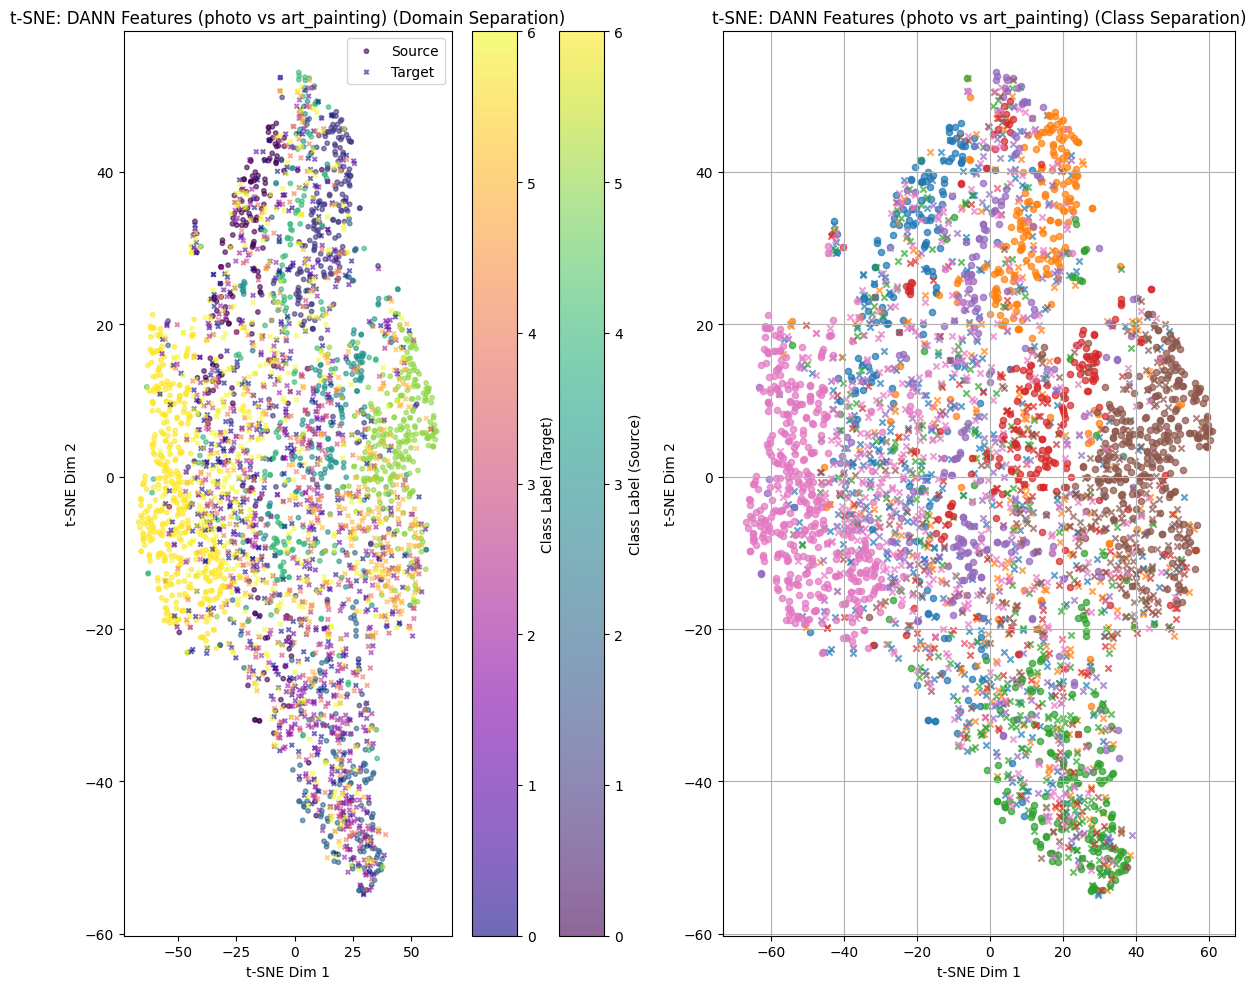

t-SNE visualization saved to tsne_dann.png


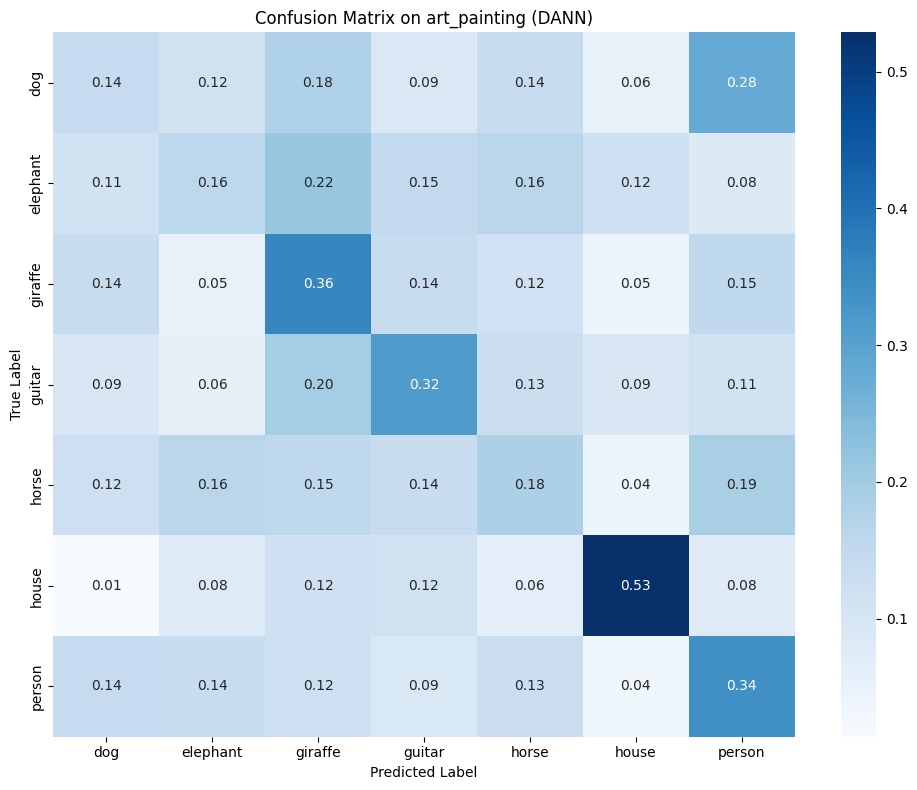

Confusion matrix saved to confusion_matrix_dann.png


In [ ]:
# Visualization and Analysis (DANN)
print("\nGenerating visualizations for DANN model...")
visualize_features_tsne(feature_extractor_dann, source_test_dataloader, target_test_dataloader,
                        title=f"t-SNE: DANN Features ({SOURCE_DOMAIN_NAME} vs {TARGET_DOMAIN_NAME})",
                        filename="tsne_dann.png")

plot_confusion_matrix(target_labels_dann_eval, target_preds_dann_eval, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (DANN)",
                      filename="confusion_matrix_dann.png")

In [ ]:
# Proxy Distance for Domain Alignment (DANN)
domain_discriminator_error_dann = calculate_domain_distance_proxy(feature_extractor_dann, source_test_dataloader, target_test_dataloader)
print(f"Proxy Domain Distance (Discriminator Error) for DANN: {domain_discriminator_error_dann:.4f}")

Training Domain Discriminator for proxy distance...
Proxy Domain Distance (Discriminator Error) for DANN: 0.1396


In [ ]:
# Storing results for comparison
dann_results = {
    "Source Accuracy": source_accuracy_dann_eval,
    "Target Accuracy": target_accuracy_dann_eval,
    "Target Preds": target_preds_dann_eval,
    "Target Labels": target_labels_dann_eval,
    "Proxy Domain Distance": domain_discriminator_error_dann
}

# --- Task 1.2.

In [ ]:
# star

In [21]:
# --- Task 1.2.3 Conditional Domain Adversarial Network (CDAN) ---
print("\n" + "="*80)
print("Task 1.2.3: Conditional Domain Adversarial Network (CDAN)")
print("="*80 + "\n")

# CDAN Model Architecture
class CDANModel(nn.Module):
    def __init__(self, feature_extractor, num_classes, feature_dim=2048):
        super(CDANModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = Classifier(feature_dim, num_classes)
        self.grl = GRL() # Using the same GRL class as DANN

        conditional_feature_dim = feature_dim + num_classes

        self.domain_classifier = nn.Sequential(
            nn.Linear(conditional_feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        class_logits = self.classifier(features)
        class_probs = F.softmax(class_logits, dim=1) # Get probabilities for conditioning

        conditional_input = torch.cat((features, class_probs), dim=1)

        self.grl.alpha = torch.tensor(alpha, requires_grad=False).to(x.device) # Update alpha
        reversed_conditional_input = self.grl(conditional_input)
        domain_output = self.domain_classifier(reversed_conditional_input)

        return class_logits, domain_output, features, class_probs


Task 1.2.3: Conditional Domain Adversarial Network (CDAN)



In [22]:
# Model Initialization for CDAN
feature_extractor_cdan = FeatureExtractor().to(device) # Shared feature extractor
cdan_model = CDANModel(feature_extractor_cdan, NUM_CLASSES, feature_dim=2048).to(device)

optimizer_cdan = optim.Adam(cdan_model.parameters(), lr=1e-3)
criterion_cdan_cls = nn.CrossEntropyLoss()
criterion_cdan_domain = nn.BCELoss()
criterion_entropy = lambda probs: -(probs * torch.log(probs + 1e-10)).sum(dim=1).mean() # Entropy minimization loss

NUM_EPOCHS_CDAN = 20
LAMBDA_CDAN_DOMAIN = 1.0 # Weight for domain adversarial loss
LAMBDA_CDAN_ENTROPY = 0.1 # Weight for entropy minimization (optional but common in CDAN)

print(f"Training CDAN model on {SOURCE_DOMAIN_NAME} (labeled) and {TARGET_DOMAIN_NAME} (unlabeled) for {NUM_EPOCHS_CDAN} epochs...")

Training CDAN model on photo (labeled) and art_painting (unlabeled) for 20 epochs...


In [23]:
# Training Loop (CDAN)
len_source_dataloader = len(source_dataloader)
len_target_dataloader = len(target_dataloader)
min_len_dataloader = min(len_source_dataloader, len_target_dataloader)

for epoch in range(NUM_EPOCHS_CDAN):
    cdan_model.train()
    running_loss_cls = 0.0
    running_loss_domain = 0.0
    running_loss_entropy = 0.0

    source_iter = iter(source_dataloader)
    target_iter = iter(target_dataloader)

    # You can schedule alpha similar to DANN, for simplicity keeping it constant here
    alpha_grl = 1.0

    for i in tqdm(range(min_len_dataloader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS_CDAN} (CDAN Training)"):
        try:
            s_inputs, s_labels = next(source_iter)
        except StopIteration:
            source_iter = iter(source_dataloader)
            s_inputs, s_labels = next(source_iter)

        try:
            t_inputs, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_dataloader)
            t_inputs, _ = next(target_iter)

        s_inputs, s_labels = s_inputs.to(device), s_labels.to(device)
        t_inputs = t_inputs.to(device)

        optimizer_cdan.zero_grad()

         # Source Domain Pass
        s_class_output, s_domain_output, s_features, s_class_probs = cdan_model(s_inputs, alpha=alpha_grl)
        loss_cls = criterion_cdan_cls(s_class_output, s_labels)

        s_domain_label = torch.zeros(s_inputs.size(0), 1).to(device)
        loss_s_domain = criterion_cdan_domain(s_domain_output, s_domain_label)

        # Target Domain Pass
        _, t_domain_output, t_features, t_class_probs = cdan_model(t_inputs, alpha=alpha_grl)
        t_domain_label = torch.ones(t_inputs.size(0), 1).to(device)
        loss_t_domain = criterion_cdan_domain(t_domain_output, t_domain_label)

        loss_domain = loss_s_domain + loss_t_domain

        # Optional: Entropy Minimization for Target predictions
        loss_entropy = criterion_entropy(t_class_probs)

        total_loss = loss_cls + LAMBDA_CDAN_DOMAIN * loss_domain + LAMBDA_CDAN_ENTROPY * loss_entropy
        total_loss.backward()
        optimizer_cdan.step()

        running_loss_cls += loss_cls.item()
        running_loss_domain += loss_domain.item()
        running_loss_entropy += loss_entropy.item()

    print(f"Epoch {epoch+1} Class Loss: {running_loss_cls / min_len_dataloader:.4f}, Domain Loss: {running_loss_domain / min_len_dataloader:.4f}, Entropy Loss: {running_loss_entropy / min_len_dataloader:.4f}")

print("\n--- CDAN Training Complete ---")


Epoch 1/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 1 Class Loss: 1.5635, Domain Loss: 1.3977, Entropy Loss: 1.5725


Epoch 2/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 2 Class Loss: 1.1975, Domain Loss: 1.3752, Entropy Loss: 1.2689


Epoch 3/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 3 Class Loss: 1.0526, Domain Loss: 1.3718, Entropy Loss: 1.1937


Epoch 4/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 4 Class Loss: 0.8986, Domain Loss: 1.3576, Entropy Loss: 1.0937


Epoch 5/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 5 Class Loss: 0.7971, Domain Loss: 1.3340, Entropy Loss: 1.0044


Epoch 6/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


Epoch 6 Class Loss: 0.8237, Domain Loss: 1.3272, Entropy Loss: 0.9843


Epoch 7/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 7 Class Loss: 0.6530, Domain Loss: 1.3233, Entropy Loss: 0.9129


Epoch 8/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 8 Class Loss: 0.5262, Domain Loss: 1.3105, Entropy Loss: 0.7929


Epoch 9/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.28it/s]


Epoch 9 Class Loss: 0.5050, Domain Loss: 1.3051, Entropy Loss: 0.7370


Epoch 10/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 10 Class Loss: 0.4654, Domain Loss: 1.3145, Entropy Loss: 0.7127


Epoch 11/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 11 Class Loss: 0.3381, Domain Loss: 1.3503, Entropy Loss: 0.5908


Epoch 12/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 12 Class Loss: 0.3009, Domain Loss: 1.3519, Entropy Loss: 0.5232


Epoch 13/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.26it/s]


Epoch 13 Class Loss: 0.2472, Domain Loss: 1.3243, Entropy Loss: 0.5049


Epoch 14/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 14 Class Loss: 0.3519, Domain Loss: 1.3627, Entropy Loss: 0.4653


Epoch 15/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 15 Class Loss: 0.2176, Domain Loss: 1.3201, Entropy Loss: 0.4471


Epoch 16/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 16 Class Loss: 0.1940, Domain Loss: 1.3639, Entropy Loss: 0.3742


Epoch 17/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.24it/s]


Epoch 17 Class Loss: 0.2208, Domain Loss: 1.3593, Entropy Loss: 0.3849


Epoch 18/20 (CDAN Training): 100%|██████████| 105/105 [00:46<00:00,  2.27it/s]


Epoch 18 Class Loss: 0.1619, Domain Loss: 1.3552, Entropy Loss: 0.3441


Epoch 19/20 (CDAN Training): 100%|██████████| 105/105 [00:49<00:00,  2.10it/s]


Epoch 19 Class Loss: 0.1441, Domain Loss: 1.3660, Entropy Loss: 0.3144


Epoch 20/20 (CDAN Training): 100%|██████████| 105/105 [00:48<00:00,  2.17it/s]

Epoch 20 Class Loss: 0.1702, Domain Loss: 1.3662, Entropy Loss: 0.2931

--- CDAN Training Complete ---


In [33]:
# Evaluation (CDAN)
print("\nEvaluating CDAN model:")
cdan_model.eval()
feature_extractor_cdan.eval() # Ensure feature extractor is also in eval mode

temp_classifier_cdan = cdan_model.classifier # Get the classification head for evaluation

source_accuracy_cdan_eval, source_preds_cdan_eval, source_labels_cdan_eval = evaluate_model(feature_extractor_cdan, temp_classifier_cdan, source_test_dataloader, domain_name=SOURCE_DOMAIN_NAME)
target_accuracy_cdan_eval, target_preds_cdan_eval, target_labels_cdan_eval = evaluate_model(feature_extractor_cdan, temp_classifier_cdan, target_test_dataloader, domain_name=TARGET_DOMAIN_NAME)

print(f"\nResults for CDAN ({SOURCE_DOMAIN_NAME} -> {TARGET_DOMAIN_NAME}):")
print(f"  Source Domain Accuracy ({SOURCE_DOMAIN_NAME}): {source_accuracy_cdan_eval:.4f}")
print(f"  Target Domain Accuracy ({TARGET_DOMAIN_NAME}): {target_accuracy_cdan_eval:.4f}")



Evaluating CDAN model:
Domain: photo, Accuracy: 0.9174
Domain: art_painting, Accuracy: 0.2925

Results for CDAN (photo -> art_painting):
  Source Domain Accuracy (photo): 0.9174
  Target Domain Accuracy (art_painting): 0.2925



Generating visualizations for CDAN model...
Extracting features for t-SNE visualization...


Target Features: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Running t-SNE...


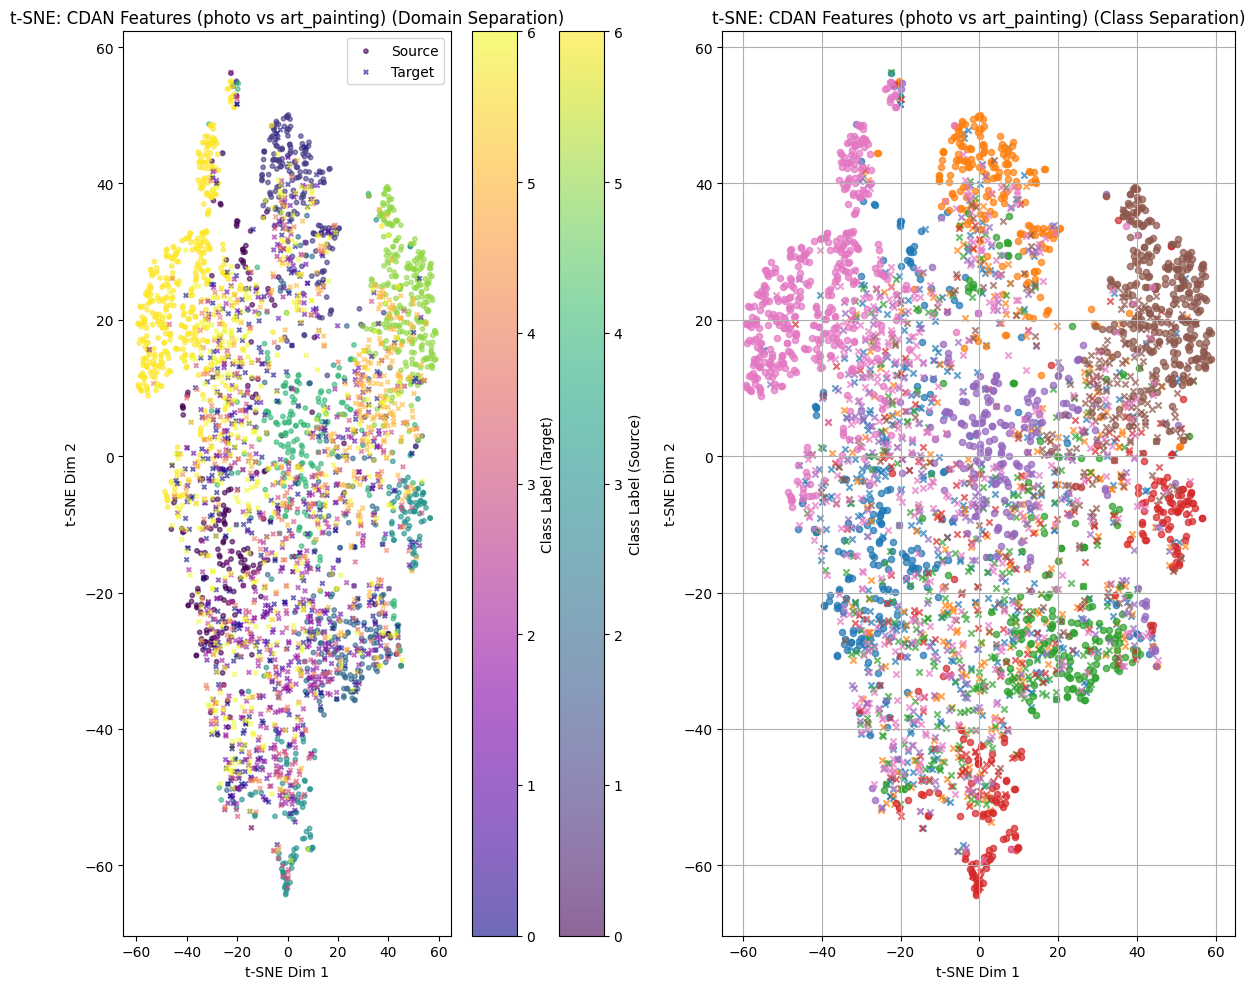

t-SNE visualization saved to tsne_cdan.png


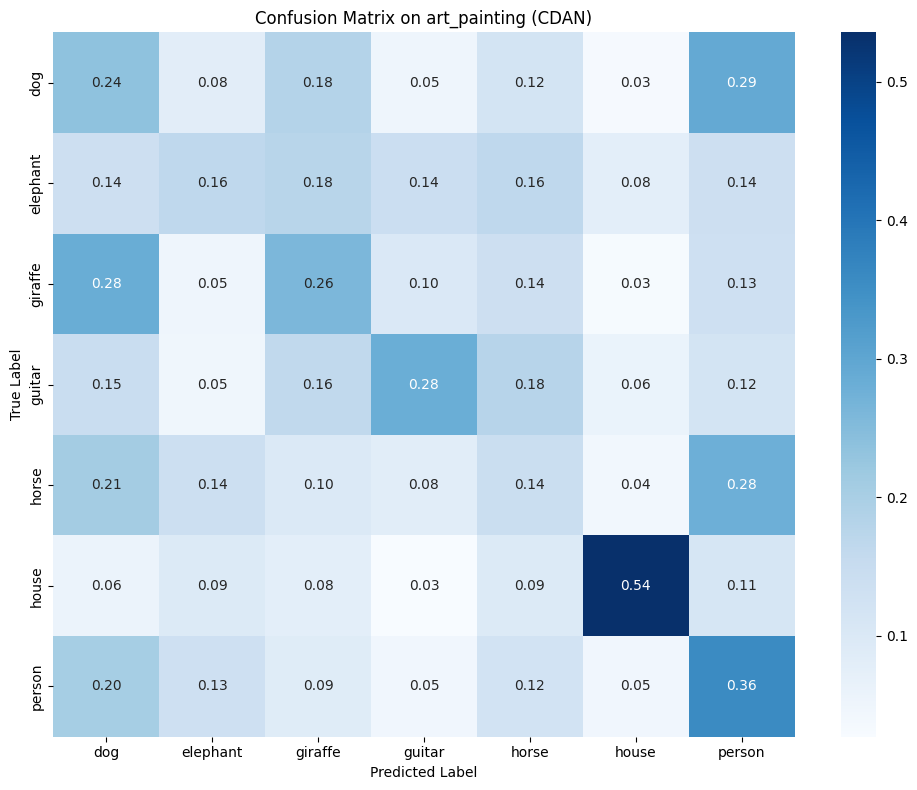

Confusion matrix saved to confusion_matrix_cdan.png


In [ ]:
# Visualization and Analysis (CDAN)
print("\nGenerating visualizations for CDAN model...")
visualize_features_tsne(feature_extractor_cdan, source_test_dataloader, target_test_dataloader,
                        title=f"t-SNE: CDAN Features ({SOURCE_DOMAIN_NAME} vs {TARGET_DOMAIN_NAME})",
                        filename="tsne_cdan.png")

plot_confusion_matrix(target_labels_cdan_eval, target_preds_cdan_eval, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (CDAN)",
                      filename="confusion_matrix_cdan.png")

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
def calculate_conditional_domain_distance_proxy(cdan_model, source_dataloader, target_dataloader):
    conditional_feature_dim_proxy = 2048 + NUM_CLASSES

    discriminator = DomainDiscriminator(conditional_feature_dim_proxy).to(device) # Reusing general DomainDiscriminator
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=1e-3)
    criterion_disc = nn.BCELoss()

    all_conditional_features = []
    all_domains_labels = []

    cdan_model.eval() # Ensure CDAN model is in eval mode

    with torch.no_grad():
        for inputs, _ in source_dataloader:
            inputs = inputs.to(device)
            _, _, features, class_probs = cdan_model(inputs) # Get features and class_probs
            conditional_input = torch.cat((features, class_probs), dim=1) # Form conditional feature
            all_conditional_features.append(conditional_input.cpu())
            all_domains_labels.append(torch.zeros(len(inputs)))

        for inputs, _ in target_dataloader:
            inputs = inputs.to(device)
            _, _, features, class_probs = cdan_model(inputs) # Get features and class_probs
            conditional_input = torch.cat((features, class_probs), dim=1) # Form conditional feature
            all_conditional_features.append(conditional_input.cpu())
            all_domains_labels.append(torch.ones(len(inputs)))

    all_conditional_features = torch.cat(all_conditional_features, dim=0)
    all_domains_labels = torch.cat(all_domains_labels, dim=0).unsqueeze(1)

    feature_dataset = FeatureDataset(all_conditional_features, all_domains_labels)
    feature_dataloader = DataLoader(feature_dataset, batch_size=64, shuffle=True)

    print("Training Conditional Domain Discriminator for CDAN proxy distance...")
    for epoch in range(5): # Fewer epochs as it's just a proxy discriminator
        discriminator.train()
        for features_batch, domain_labels_batch in feature_dataloader:
            features_batch, domain_labels_batch = features_batch.to(device), domain_labels_batch.to(device)
            optimizer_disc.zero_grad()
            preds = discriminator(features_batch)
            loss = criterion_disc(preds, domain_labels_batch)
            loss.backward()
            optimizer_disc.step()

    discriminator.eval()
    correct_domain_preds = 0
    total_domain_samples = 0
    with torch.no_grad():
        for features_batch, domain_labels_batch in feature_dataloader:
            features_batch, domain_labels_batch = features_batch.to(device), domain_labels_batch.to(device)
            preds = discriminator(features_batch)
            predicted_domains = (preds > 0.5).float()
            total_domain_samples += domain_labels_batch.size(0)
            correct_domain_preds += (predicted_domains == domain_labels_batch).sum().item()

    domain_discriminator_accuracy = correct_domain_preds / total_domain_samples
    domain_discriminator_error = 1 - domain_discriminator_accuracy
    return domain_discriminator_error


domain_discriminator_error_cdan = calculate_conditional_domain_distance_proxy(cdan_model, source_test_dataloader, target_test_dataloader)
print(f"Proxy Conditional Domain Distance (Discriminator Error) for CDAN: {domain_discriminator_error_cdan:.4f}")


Training Conditional Domain Discriminator for CDAN proxy distance...
Proxy Conditional Domain Distance (Discriminator Error) for CDAN: 0.1547


In [ ]:
# Storing results for comparison
cdan_results = {
    "Source Accuracy": source_accuracy_cdan_eval,
    "Target Accuracy": target_accuracy_cdan_eval,
    "Target Preds": target_preds_cdan_eval,
    "Target Labels": target_labels_cdan_eval,
    "Proxy Domain Distance": domain_discriminator_error_cdan
}

In [64]:
import numpy as np
from sklearn.metrics import f1_score

# --- Quantify Negative Transfer Effects ---
print("\n--- Quantifying Negative Transfer Effects via F1-Scores for Three Rarest Classes ---")

# Use target labels from source-only evaluation (assuming same for all methods)
target_labels = target_labels_so  # True labels for target domain

# Find the three rarest classes in the target domain
unique_classes, counts = np.unique(target_labels, return_counts=True)
sorted_indices = np.argsort(counts)[:3]  # Indices of three smallest counts
rarest_classes = unique_classes[sorted_indices]
rarest_counts = counts[sorted_indices]

print("Three rarest classes in target domain:")
for idx, cls in enumerate(rarest_classes):
    print(f"  Class '{CLASS_NAMES[cls]}' (Index {cls}): {rarest_counts[idx]} samples")

# Methods including source-only baseline
methods = ["Source-Only", "DAN", "DANN", "CDAN"]

# Dictionary to store F1-scores
negative_transfer_results = {method: {} for method in methods}

for method_name in methods:
    if method_name == "Source-Only":
        preds = target_preds_so
        labels = target_labels_so
    elif method_name == "DAN":
        preds = target_preds_dan
        labels = target_labels_dan
    elif method_name == "DANN":
        preds = target_preds_dann_eval
        labels = target_labels_dann_eval
    elif method_name == "CDAN":
        preds = target_preds_cdan_eval
        labels = target_labels_cdan_eval
    else:
        continue

    for rare_cls in rarest_classes:
        if np.sum(labels == rare_cls) == 0:
            f1 = "N/A (No samples)"
        else:
            # Compute per-class F1-score for the rare class
            f1_scores = f1_score(labels, preds, labels=[rare_cls], average=None, zero_division=0)
            f1 = f1_scores[0]  # Extract F1 for the specified class
        negative_transfer_results[method_name][f"F1 Class {CLASS_NAMES[rare_cls]} ({rare_cls})"] = f1

# Print results and comparisons
print("\nF1-Scores for Rarest Classes:")
for rare_cls in rarest_classes:
    cls_name = f"Class {CLASS_NAMES[rare_cls]} ({rare_cls})"
    print(f"\n{cls_name}:")
    so_f1 = negative_transfer_results["Source-Only"][f"F1 {cls_name}"]
    print(f"  Source-Only: {so_f1:.4f}" if isinstance(so_f1, float) else f"  Source-Only: {so_f1}")
    for method in methods[1:]:
        method_f1 = negative_transfer_results[method][f"F1 {cls_name}"]
        delta = method_f1 - so_f1 if isinstance(method_f1, float) and isinstance(so_f1, float) else "N/A"
        sign = " (Negative Transfer)" if isinstance(delta, float) and delta < 0 else " (Positive Transfer)" if isinstance(delta, float) and delta > 0 else ""
        print(f"  {method}: {method_f1:.4f}" if isinstance(method_f1, float) else f"  {method}: {method_f1}", f" | Delta: {delta:.4f}{sign}" if isinstance(delta, float) else "")


--- Quantifying Negative Transfer Effects via F1-Scores for Three Rarest Classes ---
Three rarest classes in target domain:
  Class 'guitar' (Index 3): 184 samples
  Class 'horse' (Index 4): 201 samples
  Class 'elephant' (Index 1): 255 samples

F1-Scores for Rarest Classes:

Class guitar (3):
  Source-Only: 0.2407
  DAN: 0.0000  | Delta: -0.2407 (Negative Transfer)
  DANN: 0.2658  | Delta: 0.0251 (Positive Transfer)
  CDAN: 0.1935  | Delta: -0.0471 (Negative Transfer)

Class horse (4):
  Source-Only: 0.1739
  DAN: 0.0000  | Delta: -0.1739 (Negative Transfer)
  DANN: 0.1201  | Delta: -0.0538 (Negative Transfer)
  CDAN: 0.1166  | Delta: -0.0573 (Negative Transfer)

Class elephant (1):
  Source-Only: 0.1988
  DAN: 0.0000  | Delta: -0.1988 (Negative Transfer)
  DANN: 0.1860  | Delta: -0.0128 (Negative Transfer)
  CDAN: 0.2304  | Delta: 0.0316 (Positive Transfer)


In [52]:
print("\n" + "="*80)
print("Task 1.3: Self-Training on Target (Pseudo-Labeling)")
print("="*80 + "\n")

feature_extractor_st = FeatureExtractor().to(device)
classifier_st = Classifier(2048, NUM_CLASSES).to(device)

# Load weights from the best Source-Only model
# In this sequential setup, feature_extractor_so and classifier_so hold the final SO weights.
feature_extractor_st.load_state_dict(feature_extractor_so.state_dict())
classifier_st.load_state_dict(classifier_so.state_dict())

optimizer_st = optim.Adam(list(feature_extractor_st.parameters()) + list(classifier_st.parameters()), lr=1e-4) # Smaller LR for fine-tuning
criterion_st = nn.CrossEntropyLoss()

NUM_EPOCHS_ST = 10 # Fine-tuning epochs

print(f"Starting Self-Training with initial model trained on {SOURCE_DOMAIN_NAME}.")



Task 1.3: Self-Training on Target (Pseudo-Labeling)

Starting Self-Training with initial model trained on photo.


In [53]:
# --- Step 1: Generate Pseudo-Labels on Target Domain ---
print("\nStep 1: Generating pseudo-labels on the target domain...")
feature_extractor_st.eval()
classifier_st.eval()

target_pseudo_labels = []
target_confidences = []
target_true_labels_for_eval = [] # Store true labels for evaluation later
target_images_for_pseudolabeling = [] # Store images to create a new dataset

with torch.no_grad():
    for inputs, labels in tqdm(target_test_dataloader, desc="Pseudo-labeling Target"):
        inputs = inputs.to(device)
        features = feature_extractor_st(inputs)
        outputs = classifier_st(features)
        probabilities = F.softmax(outputs, dim=1)
        confidences, predicted_labels = torch.max(probabilities, 1)

        target_pseudo_labels.extend(predicted_labels.cpu().numpy())
        target_confidences.extend(confidences.cpu().numpy())
        target_true_labels_for_eval.extend(labels.cpu().numpy())
        target_images_for_pseudolabeling.extend(inputs.cpu())

target_pseudo_labels = np.array(target_pseudo_labels)
target_confidences = np.array(target_confidences)
target_true_labels_for_eval = np.array(target_true_labels_for_eval)

print(f"Generated {len(target_pseudo_labels)} pseudo-labels.")


Step 1: Generating pseudo-labels on the target domain...


Pseudo-labeling Target: 100%|██████████| 128/128 [00:13<00:00,  9.46it/s]

Generated 2048 pseudo-labels.


In [55]:
# --- Confidence Filtering (Optional but Recommended) ---
CONFIDENCE_THRESHOLD = 0.9 # Only use pseudo-labels with high confidence
confident_indices = np.where(target_confidences >= CONFIDENCE_THRESHOLD)[0]

filtered_pseudo_labels = target_pseudo_labels[confident_indices]
filtered_true_labels = target_true_labels_for_eval[confident_indices] # For monitoring quality
filtered_images = [target_images_for_pseudolabeling[i] for i in confident_indices]

print(f"Filtered to {len(filtered_pseudo_labels)} pseudo-labels with confidence >= {CONFIDENCE_THRESHOLD}.")
if len(filtered_pseudo_labels) == 0:
    print("Warning: No confident pseudo-labels generated. Adjusting threshold or increasing source-only training.")
    # Fallback: if no labels, use all or reduce threshold
    if len(target_pseudo_labels) > 0:
        print("Using all pseudo-labels due to zero confident labels.")
        filtered_pseudo_labels = target_pseudo_labels
        filtered_images = target_images_for_pseudolabeling
        filtered_true_labels = target_true_labels_for_eval
    else:
        print("No target samples to pseudo-label. Skipping self-training.")
        self_training_results = source_only_results # Revert to baseline
        # Skip the rest of the self-training
        NUM_EPOCHS_ST = 0 # No epochs if no data

Filtered to 699 pseudo-labels with confidence >= 0.9.



Step 2: Fine-tuning model on 699 pseudo-labeled target samples for 10 epochs...


Epoch 1/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.77it/s]


Epoch 1 Loss: 0.3411


Epoch 2/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.73it/s]


Epoch 2 Loss: 0.0767


Epoch 3/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:08<00:00,  5.23it/s]


Epoch 3 Loss: 0.0458


Epoch 4/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.76it/s]


Epoch 4 Loss: 0.0277


Epoch 5/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.82it/s]


Epoch 5 Loss: 0.0281


Epoch 6/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.87it/s]


Epoch 6 Loss: 0.0112


Epoch 7/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.89it/s]


Epoch 7 Loss: 0.0184


Epoch 8/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.90it/s]


Epoch 8 Loss: 0.0314


Epoch 9/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.92it/s]


Epoch 9 Loss: 0.0261


Epoch 10/10 (Self-Training Fine-tuning): 100%|██████████| 44/44 [00:07<00:00,  5.88it/s]


Epoch 10 Loss: 0.0210

--- Self-Training Fine-tuning Complete ---

Evaluating Self-Trained model:
Domain: photo, Accuracy: 0.9581
Domain: art_painting, Accuracy: 0.2534

Results for Self-Training (photo -> art_painting):
  Source Domain Accuracy (photo): 0.9581
  Target Domain Accuracy (art_painting): 0.2534

Generating visualizations for Self-Training model...
Extracting features for t-SNE visualization...


Target Features: 100%|██████████| 128/128 [00:12<00:00, 10.22it/s]


Running t-SNE...


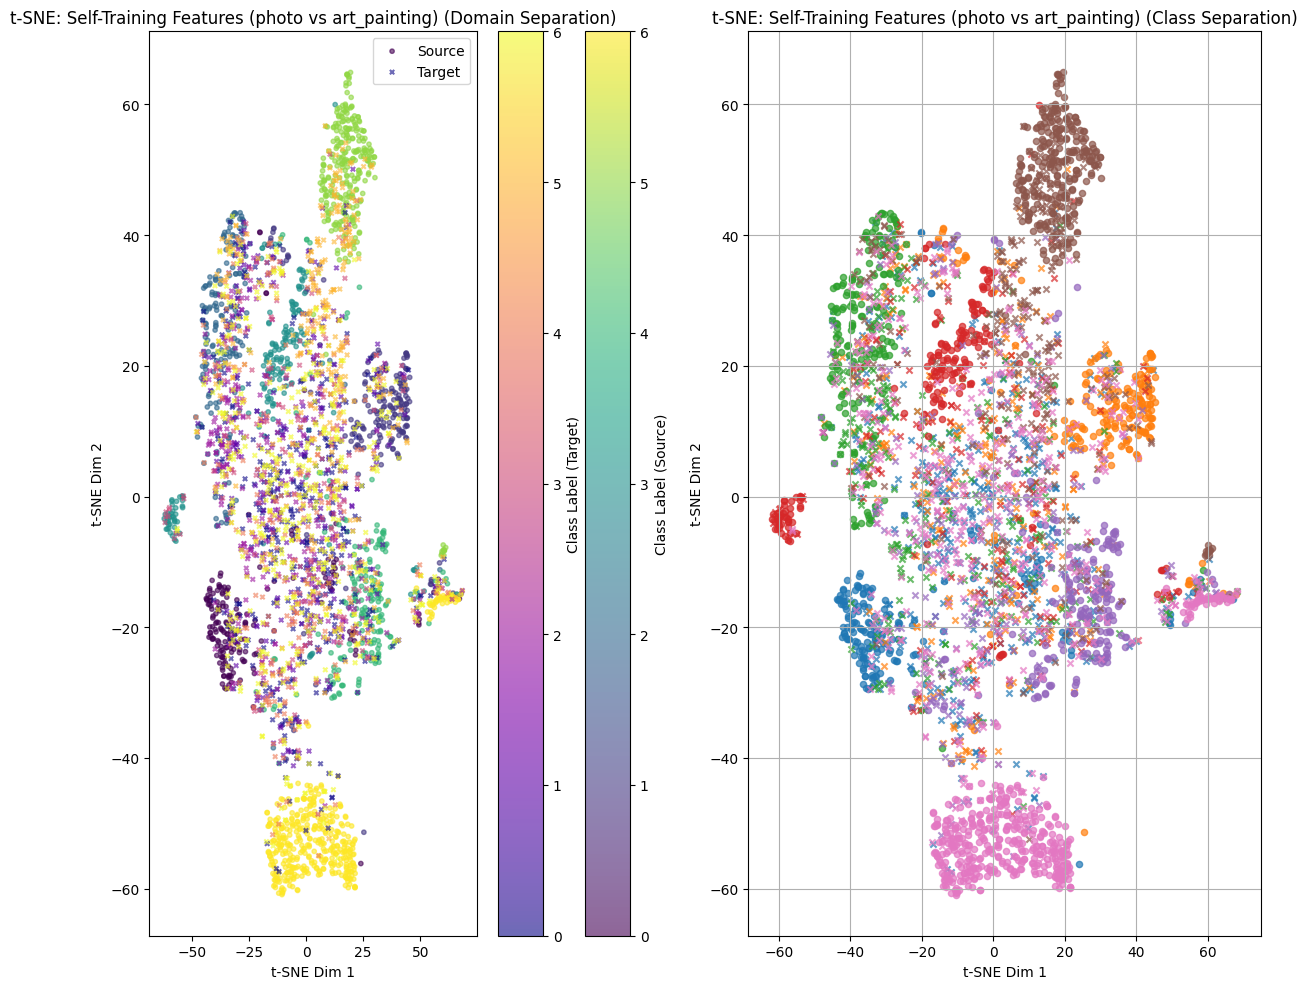

t-SNE visualization saved to tsne_self_training.png


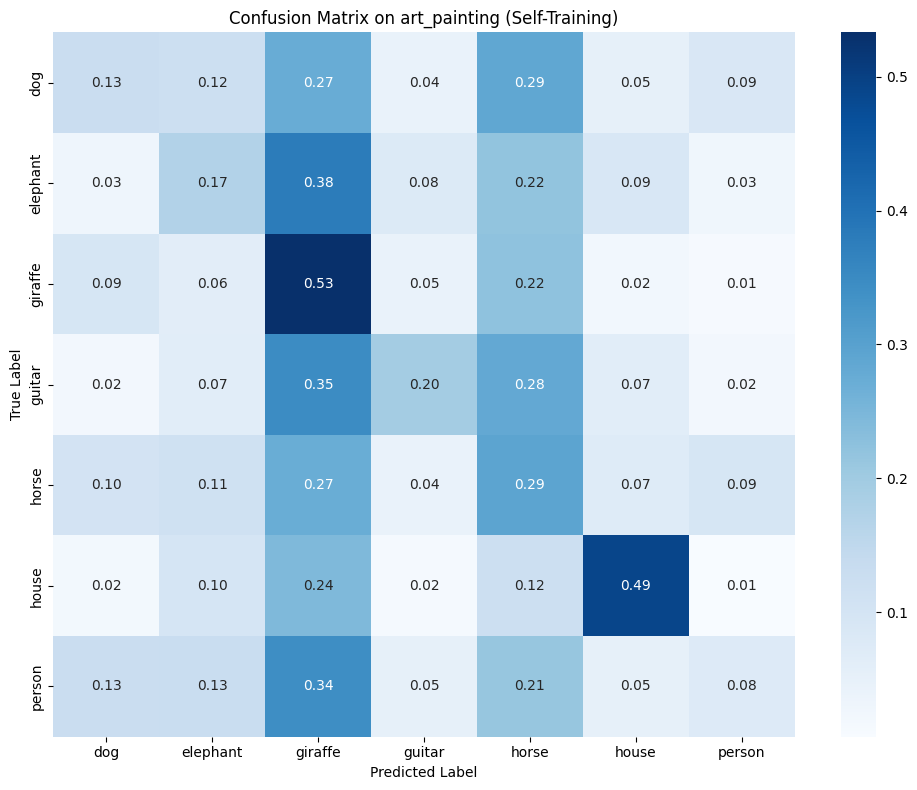

Confusion matrix saved to confusion_matrix_self_training.png
Training Domain Discriminator for proxy distance...
Proxy Domain Distance (Discriminator Error) for Self-Training: 0.1124


In [56]:
# Create a custom dataset for pseudo-labeled target data
class PseudoLabelDataset(Dataset):
    def __init__(self, images, pseudo_labels, transform=None):
        self.images = images # These are already tensors after preprocessing
        self.pseudo_labels = pseudo_labels
        self.transform = transform # Apply any further transforms if needed, but not usually here.

    def __len__(self):
        return len(self.pseudo_labels)

    def __getitem__(self, idx):
        # Images are already tensors, so just return
        image_tensor = self.images[idx]
        label = self.pseudo_labels[idx]
        return image_tensor, label

if NUM_EPOCHS_ST > 0 and len(filtered_pseudo_labels) > 0:
    pseudo_labeled_dataset = PseudoLabelDataset(filtered_images, filtered_pseudo_labels)
    pseudo_labeled_dataloader = DataLoader(pseudo_labeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # --- Step 2: Fine-tune model on Pseudo-Labeled Target Data ---
    print(f"\nStep 2: Fine-tuning model on {len(filtered_pseudo_labels)} pseudo-labeled target samples for {NUM_EPOCHS_ST} epochs...")

    for epoch in range(NUM_EPOCHS_ST):
        feature_extractor_st.train()
        classifier_st.train()
        running_loss = 0.0
        for i, (inputs, pseudo_labels) in enumerate(tqdm(pseudo_labeled_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_ST} (Self-Training Fine-tuning)")):
            inputs, pseudo_labels = inputs.to(device), pseudo_labels.to(device)

            optimizer_st.zero_grad()

            features = feature_extractor_st(inputs)
            outputs = classifier_st(features)
            loss = criterion_st(outputs, pseudo_labels)
            loss.backward()
            optimizer_st.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {running_loss / len(pseudo_labeled_dataloader):.4f}")

    print("\n--- Self-Training Fine-tuning Complete ---")

    # --- Evaluation (Self-Training) ---
    print("\nEvaluating Self-Trained model:")
    source_accuracy_st, source_preds_st, source_labels_st = evaluate_model(feature_extractor_st, classifier_st, source_test_dataloader, domain_name=SOURCE_DOMAIN_NAME)
    target_accuracy_st, target_preds_st, target_labels_st = evaluate_model(feature_extractor_st, classifier_st, target_test_dataloader, domain_name=TARGET_DOMAIN_NAME)

    print(f"\nResults for Self-Training ({SOURCE_DOMAIN_NAME} -> {TARGET_DOMAIN_NAME}):")
    print(f"  Source Domain Accuracy ({SOURCE_DOMAIN_NAME}): {source_accuracy_st:.4f}")
    print(f"  Target Domain Accuracy ({TARGET_DOMAIN_NAME}): {target_accuracy_st:.4f}")

    # --- Visualization and Analysis (Self-Training) ---
    print("\nGenerating visualizations for Self-Training model...")
    visualize_features_tsne(feature_extractor_st, source_test_dataloader, target_test_dataloader,
                            title=f"t-SNE: Self-Training Features ({SOURCE_DOMAIN_NAME} vs {TARGET_DOMAIN_NAME})",
                            filename="tsne_self_training.png")

    plot_confusion_matrix(target_labels_st, target_preds_st, CLASS_NAMES,
                          title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (Self-Training)",
                          filename="confusion_matrix_self_training.png")

    # --- Proxy Distance for Domain Alignment (Self-Training) ---
    domain_discriminator_error_st = calculate_domain_distance_proxy(feature_extractor_st, source_test_dataloader, target_test_dataloader)
    print(f"Proxy Domain Distance (Discriminator Error) for Self-Training: {domain_discriminator_error_st:.4f}")

    # Storing results for comparison
    self_training_results = {
        "Source Accuracy": source_accuracy_st,
        "Target Accuracy": target_accuracy_st,
        "Target Preds": target_preds_st,
        "Target Labels": target_labels_st,
        "Proxy Domain Distance": domain_discriminator_error_st
    }
else:
    print("Self-training skipped due to insufficient confident pseudo-labels or no target data.")
    self_training_results = source_only_results # Revert to baseline for result comparison if skipped



In [44]:
print("\n" + "="*80)
print("Task 1.4: Concept Shift (Mild) - Rare-Class Scenario")
print("="*80 + "\n")

# --- Create Modified Target DataLoader for Concept Shift ---
# We'll create a new dataset where one class is under-represented in the target.
# Let's choose a class to be 'rare'. For example, let's make CLASS_NAMES[0] ('dog') rare.
RARE_CLASS_INDEX = 0 # Example: 'dog' is class 0 in PACS
RARE_CLASS_REDUCTION_FACTOR = 0.1 # Reduce its samples to 10%

print(f"Creating a simulated concept shift scenario: Class '{CLASS_NAMES[RARE_CLASS_INDEX]}' will be made rare in the target domain.")

# Get original target dataset
original_target_dataset = domain_data[TARGET_DOMAIN_NAME]["dataset"]


Task 1.4: Concept Shift (Mild) - Rare-Class Scenario

Creating a simulated concept shift scenario: Class 'dog' will be made rare in the target domain.


In [45]:
# Separate samples by class
class_samples = {i: [] for i in range(NUM_CLASSES)}
for i in tqdm(range(len(original_target_dataset)), desc="Categorizing Target Samples"):
    _, label = original_target_dataset[i]
    class_samples[label].append(i)

# Create a new list of indices for the modified target dataset
modified_target_indices = []
for class_idx in range(NUM_CLASSES):
    samples_for_class = class_samples[class_idx]
    if class_idx == RARE_CLASS_INDEX:
        # Reduce samples for the rare class
        num_to_keep = int(len(samples_for_class) * RARE_CLASS_REDUCTION_FACTOR)
        modified_target_indices.extend(random.sample(samples_for_class, num_to_keep))
        print(f"  Class {CLASS_NAMES[class_idx]} (Original: {len(samples_for_class)}, Kept: {num_to_keep})")
    else:
        # Keep all other classes
        modified_target_indices.extend(samples_for_class)
        print(f"  Class {CLASS_NAMES[class_idx]} (Kept all {len(samples_for_class)})")

# Create a Subset dataset
modified_target_dataset = torch.utils.data.Subset(original_target_dataset, modified_target_indices)
modified_target_dataloader = DataLoader(modified_target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Also create a modified target dataloader with shuffle=True for training if needed by a method
modified_target_train_dataloader = DataLoader(modified_target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


print(f"Modified target dataset created with {len(modified_target_dataset)} samples.")
print(f"Original target dataset had {len(original_target_dataset)} samples.")

# --- Evaluate All Methods under Concept Shift ---
print("\nEvaluating all trained models under the simulated concept shift (rare-class scenario):")

# Store results for comparison table
concept_shift_results = {}


Categorizing Target Samples: 100%|██████████| 2048/2048 [00:06<00:00, 331.30it/s]

  Class dog (Original: 379, Kept: 37)
  Class elephant (Kept all 255)
  Class giraffe (Kept all 285)
  Class guitar (Kept all 184)
  Class horse (Kept all 201)
  Class house (Kept all 295)
  Class person (Kept all 449)
Modified target dataset created with 1706 samples.
Original target dataset had 2048 samples.

Evaluating all trained models under the simulated concept shift (rare-class scenario):



--- Source-Only Baseline (Concept Shift) ---
Domain: art_painting (Concept Shift), Accuracy: 0.2603


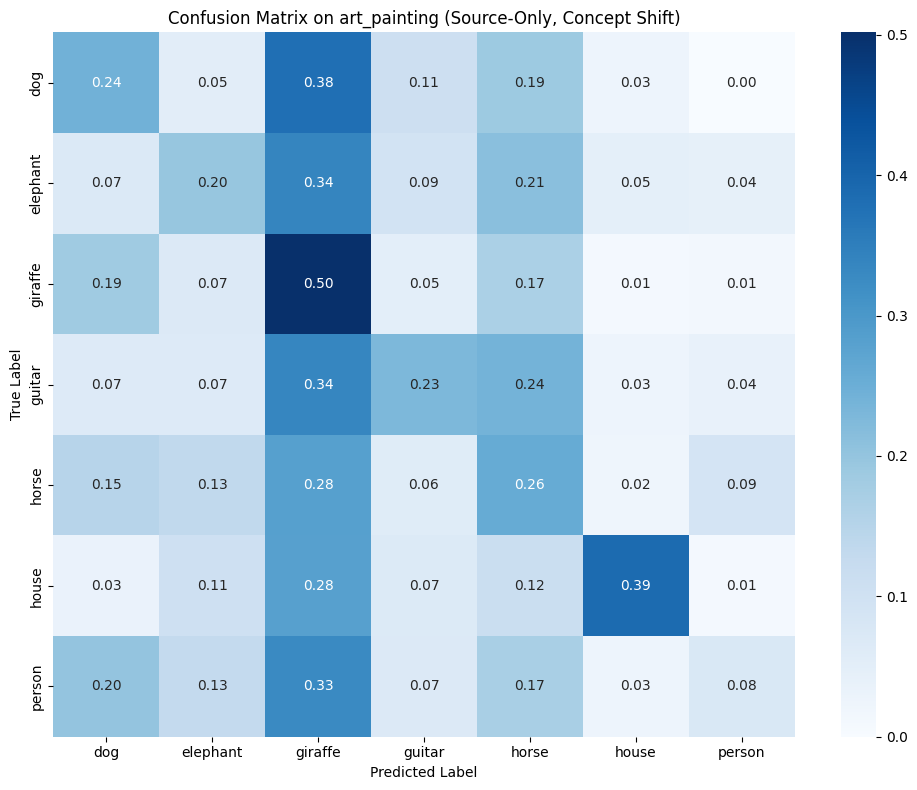

Confusion matrix saved to confusion_matrix_so_concept_shift.png


In [46]:
# 1. Source-Only Baseline (re-evaluate with new target distribution)
print("\n--- Source-Only Baseline (Concept Shift) ---")
_, target_preds_so_cs, target_labels_so_cs = evaluate_model(feature_extractor_so, classifier_so, modified_target_dataloader, domain_name=f"{TARGET_DOMAIN_NAME} (Concept Shift)")
acc_so_cs = accuracy_score(target_labels_so_cs, target_preds_so_cs)
concept_shift_results["Source-Only"] = {"Target Accuracy": acc_so_cs}
plot_confusion_matrix(target_labels_so_cs, target_preds_so_cs, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (Source-Only, Concept Shift)",
                      filename="confusion_matrix_so_concept_shift.png")



--- DAN (Concept Shift) ---
Domain: art_painting (Concept Shift), Accuracy: 0.2632


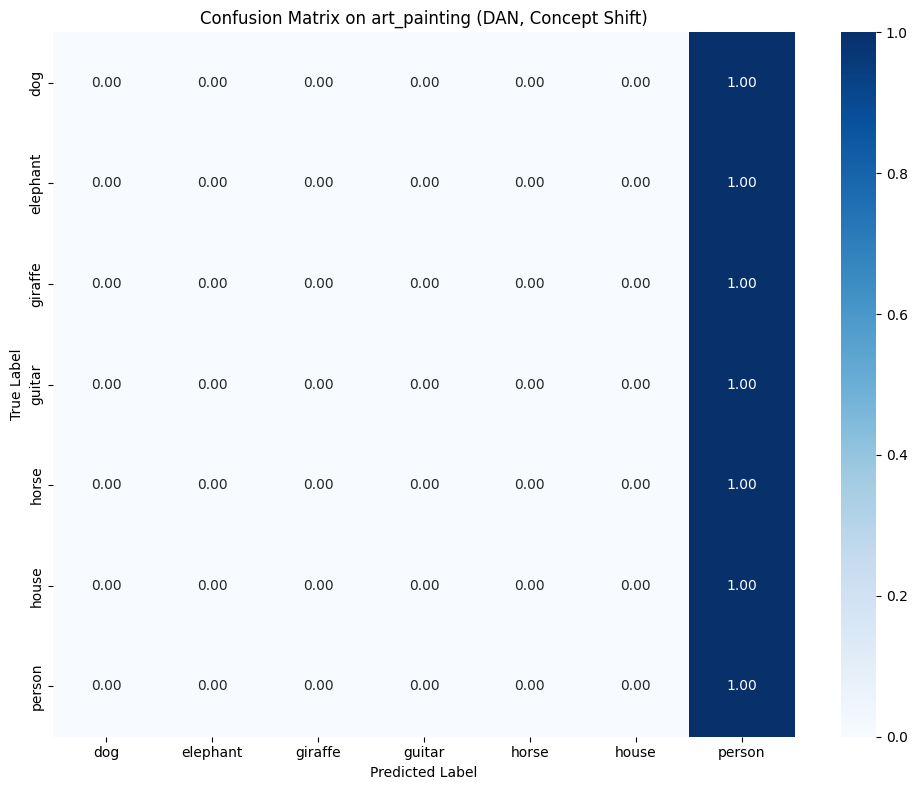

Confusion matrix saved to confusion_matrix_dan_concept_shift.png


In [47]:
# 2. DAN (re-evaluate with new target distribution)
print("\n--- DAN (Concept Shift) ---")
_, target_preds_dan_cs, target_labels_dan_cs = evaluate_model(feature_extractor_dan, classifier_dan, modified_target_dataloader, domain_name=f"{TARGET_DOMAIN_NAME} (Concept Shift)")
acc_dan_cs = accuracy_score(target_labels_dan_cs, target_preds_dan_cs)
concept_shift_results["DAN"] = {"Target Accuracy": acc_dan_cs}
plot_confusion_matrix(target_labels_dan_cs, target_preds_dan_cs, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (DAN, Concept Shift)",
                      filename="confusion_matrix_dan_concept_shift.png")


--- DANN (Concept Shift) ---
Domain: art_painting (Concept Shift), Accuracy: 0.3025


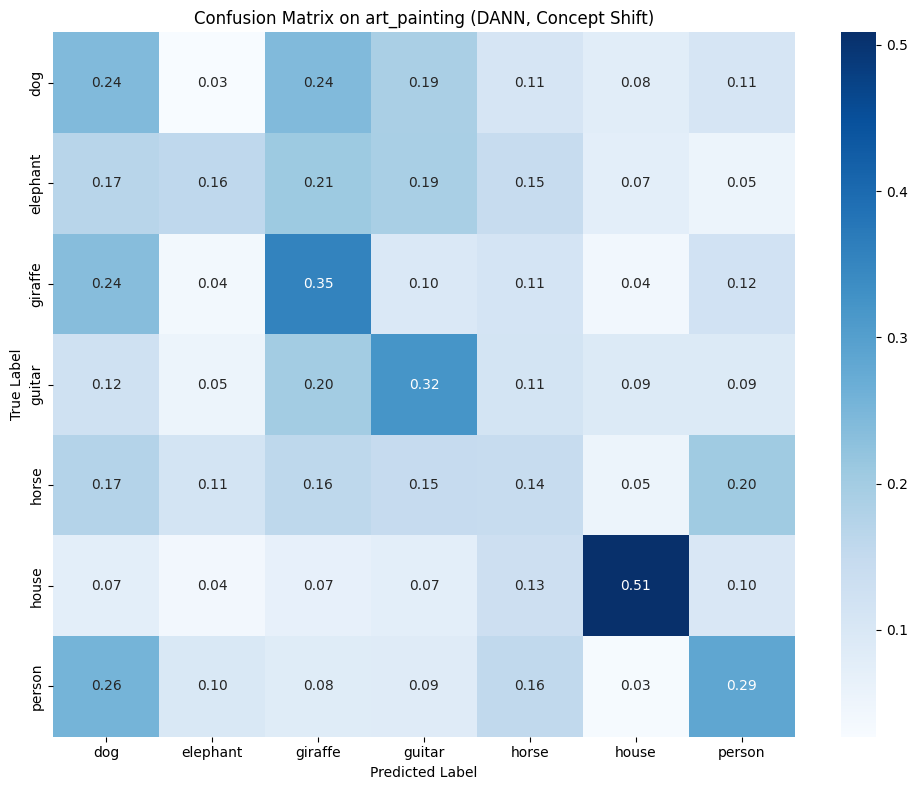

Confusion matrix saved to confusion_matrix_dann_concept_shift.png


In [48]:
# 3. DANN (re-evaluate with new target distribution)
print("\n--- DANN (Concept Shift) ---")
dann_model.eval() # Ensure DANN model is in eval mode
_, target_preds_dann_cs, target_labels_dann_cs = evaluate_model(feature_extractor_dann, dann_model.classifier, modified_target_dataloader, domain_name=f"{TARGET_DOMAIN_NAME} (Concept Shift)")
acc_dann_cs = accuracy_score(target_labels_dann_cs, target_preds_dann_cs)
concept_shift_results["DANN"] = {"Target Accuracy": acc_dann_cs}
plot_confusion_matrix(target_labels_dann_cs, target_preds_dann_cs, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (DANN, Concept Shift)",
                      filename="confusion_matrix_dann_concept_shift.png")


--- CDAN (Concept Shift) ---
Domain: art_painting (Concept Shift), Accuracy: 0.3083


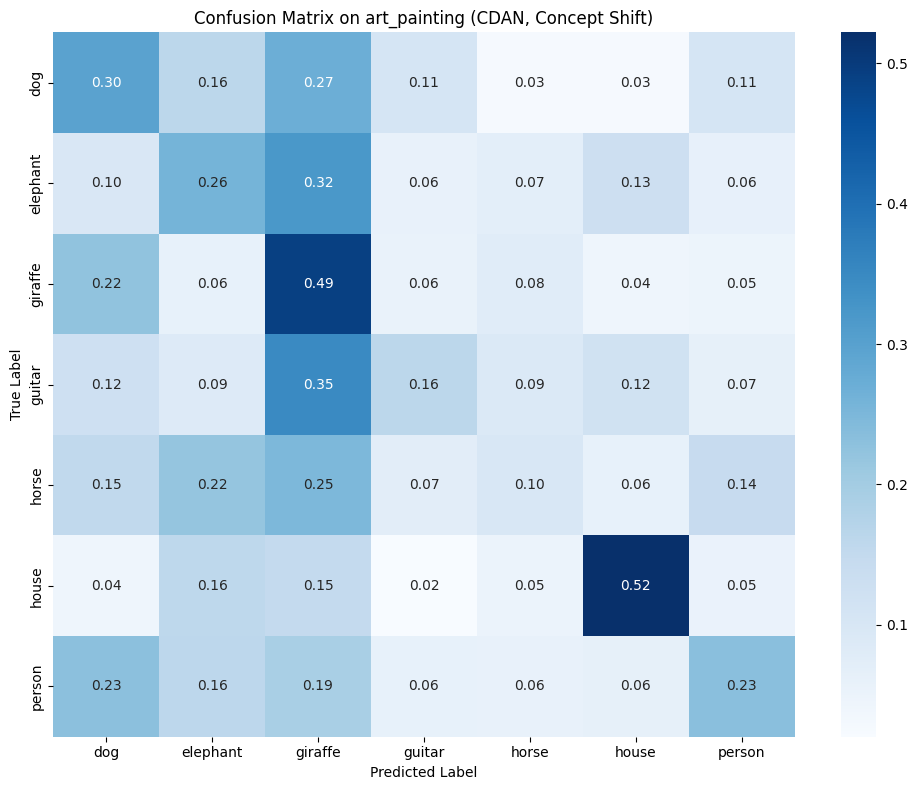

Confusion matrix saved to confusion_matrix_cdan_concept_shift.png


In [49]:
# 3. CDAN (re-evaluate with new target distribution)
print("\n--- CDAN (Concept Shift) ---")
dann_model.eval() # Ensure DANN model is in eval mode
_, target_preds_cdan_cs, target_labels_cdan_cs = evaluate_model(feature_extractor_cdan, cdan_model.classifier, modified_target_dataloader, domain_name=f"{TARGET_DOMAIN_NAME} (Concept Shift)")
acc_cdan_cs = accuracy_score(target_labels_cdan_cs, target_preds_cdan_cs)
concept_shift_results["CDAN"] = {"Target Accuracy": acc_cdan_cs}
plot_confusion_matrix(target_labels_cdan_cs, target_preds_cdan_cs, CLASS_NAMES,
                      title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (CDAN, Concept Shift)",
                      filename="confusion_matrix_cdan_concept_shift.png")


--- Self-Training (Concept Shift) ---
Domain: art_painting (Concept Shift), Accuracy: 0.2790


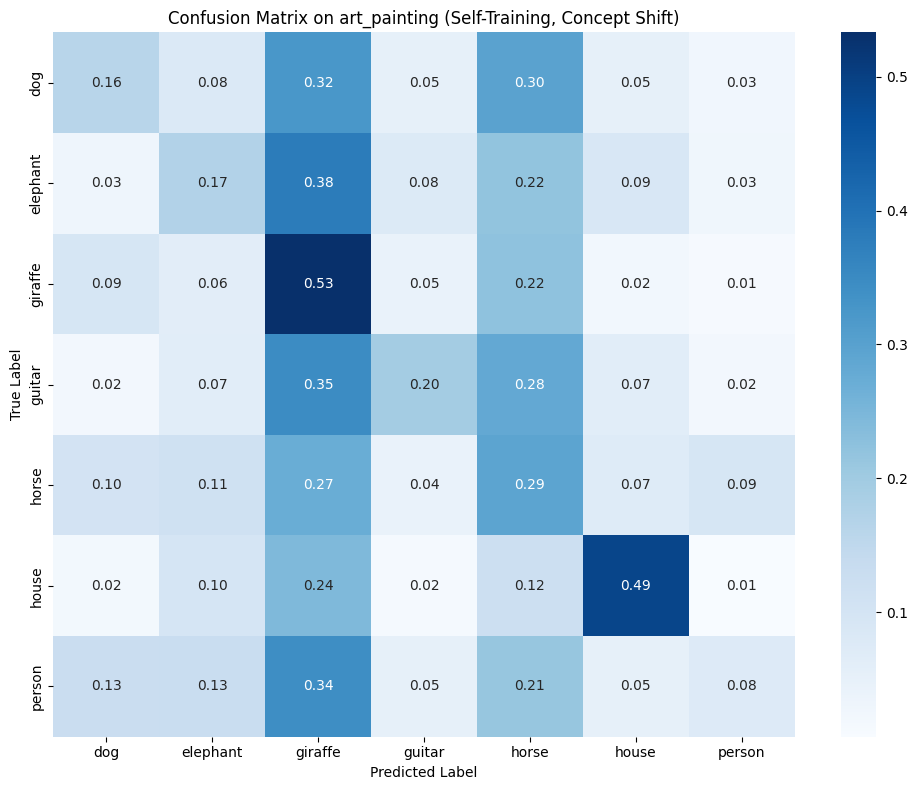

Confusion matrix saved to confusion_matrix_st_concept_shift.png


In [61]:
# 4. Self-Training (re-evaluate with new target distribution)
if 'self_training_results' in globals() and 'feature_extractor_st' in globals(): # Check if self-training was run
    print("\n--- Self-Training (Concept Shift) ---")
    _, target_preds_st_cs, target_labels_st_cs = evaluate_model(feature_extractor_st, classifier_st, modified_target_dataloader, domain_name=f"{TARGET_DOMAIN_NAME} (Concept Shift)")
    acc_st_cs = accuracy_score(target_labels_st_cs, target_preds_st_cs)
    concept_shift_results["Self-Training"] = {"Target Accuracy": acc_st_cs}
    plot_confusion_matrix(target_labels_st_cs, target_preds_st_cs, CLASS_NAMES,
                          title=f"Confusion Matrix on {TARGET_DOMAIN_NAME} (Self-Training, Concept Shift)",
                          filename="confusion_matrix_st_concept_shift.png")
else:
    print("\nSelf-Training model not available for concept shift evaluation (was skipped previously).")
    concept_shift_results["Self-Training"] = {"Target Accuracy": "N/A"}



--- Detailed Analysis for Concept Shift ---

F1-Scores for Rare Class 'dog' (Class Index 0) on Concept Shifted Target:
  Source-Only: 0.0695
  DAN: 0.0000
  DANN: 0.0513
  CDAN: 0.0714
  Self-Training: 0.0719

Overall Target Accuracy (Concept Shifted Target):
  Source-Only: 0.2603
  DAN: 0.2632
  DANN: 0.3025
  CDAN: 0.3083
  Self-Training: 0.2790


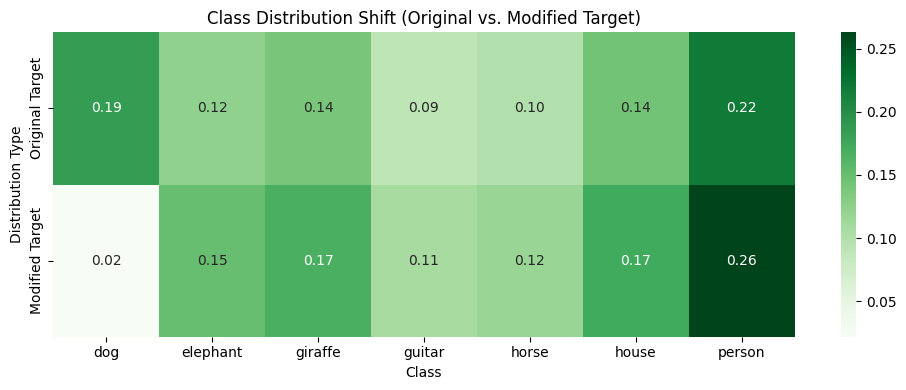

In [62]:
# --- Analysis of Worst-Group Accuracy and Rare Class F1-score ---
print("\n--- Detailed Analysis for Concept Shift ---")

# Calculate F1-score for the rare class and compare
print(f"\nF1-Scores for Rare Class '{CLASS_NAMES[RARE_CLASS_INDEX]}' (Class Index {RARE_CLASS_INDEX}) on Concept Shifted Target:")

methods = ["Source-Only", "DAN", "DANN", "CDAN", "Self-Training"]

for method_name in methods:
    if method_name == "Source-Only":
        preds = target_preds_so_cs
        labels = target_labels_so_cs
    elif method_name == "DAN":
        preds = target_preds_dan_cs
        labels = target_labels_dan_cs
    elif method_name == "DANN":
        preds = target_preds_dann_cs
        labels = target_labels_dann_cs
    elif method_name == "CDAN":
        preds = target_preds_cdan_cs
        labels = target_labels_cdan_cs
    elif method_name == "Self-Training":
        preds = target_preds_st_cs
        labels = target_labels_st_cs
    else:
        continue # Should not happen

    # Filter for the rare class (true labels) to calculate F1 for that class
    rare_class_true = labels == RARE_CLASS_INDEX
    if np.sum(rare_class_true) == 0:
        f1 = "N/A (No samples of rare class in target for evaluation)"
    else:
        # F1 score for a single class can be calculated by treating it as positive and others as negative
        f1 = f1_score(labels, preds, labels=[RARE_CLASS_INDEX], average='macro', zero_division=0)
    concept_shift_results[method_name][f"F1 Rare Class {CLASS_NAMES[RARE_CLASS_INDEX]}"] = f1
    print(f"  {method_name}: {f1:.4f}" if isinstance(f1, float) else f"  {method_name}: {f1}")

# Overall Target Accuracy (Worst-Group in this single shift scenario)
print("\nOverall Target Accuracy (Concept Shifted Target):")
for method_name, res in concept_shift_results.items():
    print(f"  {method_name}: {res['Target Accuracy']:.4f}")

# --- Heatmap of Class Distribution Shift ---
# Original Target Distribution
original_target_labels = np.array([label for _, label in original_target_dataset])
unique_orig, counts_orig = np.unique(original_target_labels, return_counts=True)
orig_dist = np.zeros(NUM_CLASSES)
for u, c in zip(unique_orig, counts_orig):
    orig_dist[u] = c / len(original_target_labels)

# Modified Target Distribution
unique_mod, counts_mod = np.unique(target_labels_so_cs, return_counts=True) # Any method's labels are fine here
mod_dist = np.zeros(NUM_CLASSES)
for u, c in zip(unique_mod, counts_mod):
    mod_dist[u] = c / len(target_labels_so_cs)

# Create a heatmap
dist_data = np.vstack([orig_dist, mod_dist])
plt.figure(figsize=(10, 4))
sns.heatmap(dist_data, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=CLASS_NAMES, yticklabels=["Original Target", "Modified Target"])
plt.title("Class Distribution Shift (Original vs. Modified Target)")
plt.xlabel("Class")
plt.ylabel("Distribution Type")
plt.tight_layout()
plt.savefig("class_distribution_shift_heatmap.png")
plt.show()
